In [1]:
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
from pprint import pprint

from earthpy.spatial import stack as es_stack
import xarray as xr

import pickle

# aggregating
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import block_reduce

# mapping
import cartopy
import cartopy.crs as ccrs

from matplotlib import colors
import matplotlib.gridspec as gridspec

import pandas as pd
import calendar
import imageio # animation
from helpers import *
from affine import Affine
from pylab import *

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)



# write out the rasters
def write_out(xarr, fname, meta_file):
    
    # load metadata
    with open(meta_file, 'rb') as fp:
        meta = pickle.load(fp)
        
    with rio.open(fname, 'w', **meta) as dst:
        dst.write(xarr[np.newaxis,...].astype(np.float32))
        
    return None

def write_out_agg(xarr, fname, meta_file, agg=0.25):
    
    # load metadata
    with open(meta_file, 'rb') as fp:
        meta = pickle.load(fp)
        
    if agg != 0.25:

        # restructure affine
        orig_size = meta['transform'].a
        agg_size = agg
        factor = agg_size/orig_size

        # calculate the new rows/cols
        new_height = int(np.floor_divide(meta['height'], factor))
        new_width = int(np.floor_divide(meta['width'], factor))

        # calculate the new center point for the upper left
        new_ul_x = meta['transform'].c - orig_size + agg_size/2
        new_ul_y =  meta['transform'].f + orig_size - agg_size/2

        # generate the new transform
        new_transform = Affine(agg_size, 0.0, new_ul_x, 
                               0.0, -agg_size, new_ul_y)

        # dictionary to update the metadata
        update_dict = {'height': new_height,
                       'width': new_width,
                      'transform': new_transform}

        meta.update(update_dict)

    with rio.open(fname, 'w', **meta) as dst:
        dst.write(xarr[np.newaxis,...].astype(np.float32))
        
    return None



PyTables is not installed. No support for HDF output.


In [2]:
matplotlib.rcParams['font.family'], matplotlib.font_manager.findfont(matplotlib.font_manager.FontProperties(family=['sans-serif']))

(['normal'],
 'C:\\software\\anaconda3\\envs\\eapy_gbdx\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf')

In [3]:
raster_folder = r"../vars_refresh_may2021/CSV_nocorn_grid_0_25_degree_vars/"
var = 'AFC_num' # [AFC_num, AFC_perc, FRP_mean, FRP_max, FRP_total]
year = 2012

day_files, night_files = get_fire_year_files(raster_folder, var, year)

## load John's VPD data

{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32768.0, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875)}


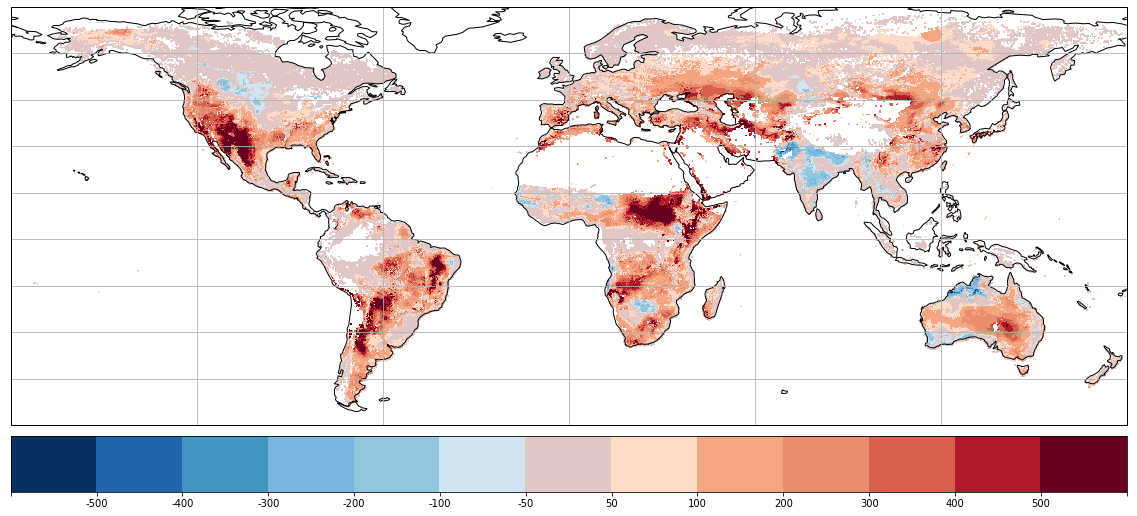

In [4]:
with rio.open('../fromJohn_Idaho_v3/nighthours_trend.nc') as src:
    print(src.profile)
    vpd=src.read(1)


vpd_data = vpd
template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
with rio.open(template) as src:
    meta = src.meta
    print(meta)

o_tform = meta['transform']


tform = o_tform.translation(-180,-15) * o_tform

# dif_affine = np.array(meta['transform']) - [0, 0, 0, 0, 0, 0]
# print(dif_affine)

#num_x = meta['width']
#num_y = meta['height']

vnum_x = vpd_data.shape[1]
vnum_y = vpd_data.shape[0]

# incorporate aggregation factor
vtlon = np.linspace(tform.c - tform.a, tform.c+vnum_x*tform.a, vnum_x)
vtlat = np.linspace(tform.f - tform.e, tform.f+vnum_y*tform.e, vnum_y)
vlon2d, vlat2d = np.meshgrid(vtlon, vtlat)

# make data into xarray with location
v_xdata = xr.DataArray(vpd_data, coords=[vtlat, vtlon], dims=['lat', 'lon'])
v_xdata = xr.where(v_xdata == 0, np.nan, v_xdata)
v_xdata = xr.where(v_xdata == -9999, np.nan, v_xdata)

# fig, ax = plt.subplots(1,1, projection=ccrs.PlateCarree(central_longitude=0))
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines()
ax.gridlines()

del colors
# colors = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']
# colors= [(100,0,20),
#          (103,0,31),(178,24,43),(214,96,77),(244,165,130),(253,219,199),(247,247,247),(209,229,240),(146,197,222),(67,147,195),(33,102,172),(5,48,97),
#          (12,35,61)]
# colors = list(np.array(colors)/255)

colors = [(103,0,31),(178,24,43),(214,96,77),(232, 142, 111),
          (244,165,130),(253,219,199),(224, 199, 197),(209,229,240),(146,197,222), (121, 181, 224),
          (67,147,195),(33,102,172),(5,48,97)]
colors = list(np.array(colors)/255)

colors.reverse()
cmap = matplotlib.colors.ListedColormap(colors)
bounds = [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500]
bounds_labels = [''] + bounds + ['']
bounds = [-600] + bounds + [600]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)

cf4 = v_xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
ax.set_ylim(-60,75)

# ax.set_title('NIGHTTIME %')

cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                   boundaries=bounds, 
                   norm=norm, 
                   cmap=cmap,
                   ticks=bounds)
cb4.set_ticklabels(bounds_labels)

plt.savefig(r'C:\users\jomc9287\desktop\nighthourstrend_v2.png')

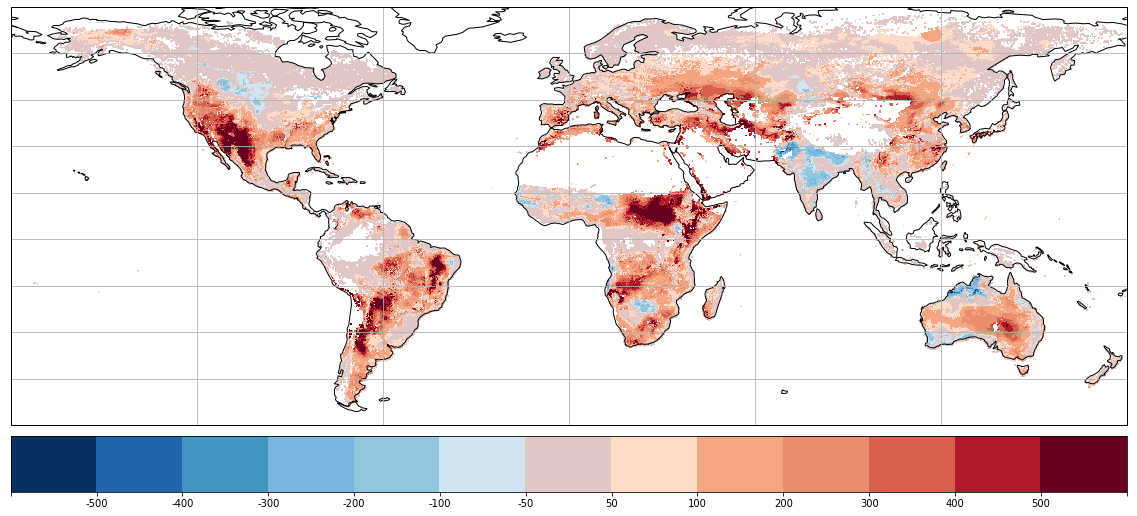

In [5]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines()
ax.gridlines()

colors = [(103,0,31),(178,24,43),(214,96,77),(232, 142, 111),
          (244,165,130),(253,219,199),(224, 199, 197),(209,229,240),(146,197,222), (121, 181, 224),
          (67,147,195),(33,102,172),(5,48,97)]
colors = list(np.array(colors)/255)

colors.reverse()
cmap = matplotlib.colors.ListedColormap(colors)
bounds = [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500]
bounds_labels = [''] + bounds + ['']
bounds = [-600] + bounds + [600]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)

v_xdata1 = v_xdata.copy()
# repl_arr = np.roll(xr_gldas_mask.values, -180*4, axis=-1)[:,15*4-1:-8*4+1,:]
# v_xdata1.values = v_xdata1.values*repl_arr[0]
cf4 = v_xdata1.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
ax.set_ylim(-60,75)

# ax.set_title('NIGHTTIME %')

cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                   boundaries=bounds, 
                   norm=norm, 
                   cmap=cmap,
                   ticks=bounds)
cb4.set_ticklabels(bounds_labels)

In [6]:
def save_vpd_fig(fname, bounds_list, raster_folder):
    
    font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

    matplotlib.rc('font', **font)

    with rio.open(fname) as src:
        print(src.profile)
        vpd=src.read(1)
    
    

    vpd_data = vpd
    template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
    with rio.open(template) as src:
        meta = src.meta
        print(meta)

    o_tform = meta['transform']
    
    tform = o_tform.translation(-180,-15) * o_tform

    # dif_affine = np.array(meta['transform']) - [0, 0, 0, 0, 0, 0]
    # print(dif_affine)

    #num_x = meta['width']
    #num_y = meta['height']

    vnum_x = vpd_data.shape[1]
    vnum_y = vpd_data.shape[0]

    # incorporate aggregation factor
    vtlon = np.linspace(tform.c - tform.a, tform.c+vnum_x*tform.a, vnum_x)
    vtlat = np.linspace(tform.f - tform.e, tform.f+vnum_y*tform.e, vnum_y)
    vlon2d, vlat2d = np.meshgrid(vtlon, vtlat)

    # make data into xarray with location
    v_xdata = xr.DataArray(vpd_data, coords=[vtlat, vtlon], dims=['lat', 'lon'])
    v_xdata = xr.where(v_xdata == 0, np.nan, v_xdata)
    v_xdata = xr.where(v_xdata == -9999, np.nan, v_xdata)
    
    if 'annualVPDtrend' in fname:
        v_xdata/=10

    # fig, ax = plt.subplots(1,1, projection=ccrs.PlateCarree(central_longitude=0))
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_global()
    ax.coastlines()
    #ax.gridlines()


    colors = [(103,0,31),(178,24,43),(214,96,77),(232, 142, 111),
              (244,165,130),(253,219,199),(240, 235, 235),(209,229,240),(146,197,222), (121, 181, 224),
              (67,147,195),(33,102,172),(5,48,97)]
    colors = list(np.array(colors)/255)

    colors.reverse()
    cmap = matplotlib.colors.ListedColormap(colors)
    #bounds = [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500]
    bounds = bounds_list
    bounds_labels = [''] + bounds + ['']
    bounds = [-600] + bounds + [600]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)

    cf4 = v_xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
    ax.set_ylim(-60, 75)
    
    # ax.set_title('NIGHTTIME %')

    cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                       boundaries=bounds, 
                       norm=norm, 
                       cmap=cmap,
                       ticks=bounds)
    cb4.set_ticklabels(bounds_labels)

    fig.tight_layout()
    fig_name = os.path.basename(fname).split('.')[0]
    plt.savefig(f'../fromJohn_Idaho_v3/{fig_name}.png')
    
def save_vpd_fig_GLDAS(fname, bounds_list, raster_folder, gl,title):
    
    font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

    matplotlib.rc('font', **font)

    with rio.open(fname) as src:
        print(src.profile)
        vpd=src.read(1)
    
    

    vpd_data = vpd
    template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
    with rio.open(template) as src:
        meta = src.meta
        #print(meta)

    o_tform = meta['transform']
    
    tform = o_tform.translation(-180,-15) * o_tform

    # dif_affine = np.array(meta['transform']) - [0, 0, 0, 0, 0, 0]
    # print(dif_affine)

    #num_x = meta['width']
    #num_y = meta['height']

    
    
    vnum_x = vpd_data.shape[1]
    vnum_y = vpd_data.shape[0]

    # incorporate aggregation factor
    vtlon = np.linspace(tform.c - tform.a, tform.c+vnum_x*tform.a, vnum_x)
    vtlat = np.linspace(tform.f - tform.e, tform.f+vnum_y*tform.e, vnum_y)
    vlon2d, vlat2d = np.meshgrid(vtlon, vtlat)

    # make data into xarray with location
    v_xdata = xr.DataArray(vpd_data, coords=[vtlat, vtlon], dims=['lat', 'lon'])
    v_xdata = xr.where(v_xdata == 0, np.nan, v_xdata) # MAYBE THIS WILL LOOK MORE COMPLETE?
    v_xdata = xr.where(v_xdata == -9999, np.nan, v_xdata)
    
    # incorporate GLDAS data
    v_xdata1 = v_xdata.copy()

    if 'vpdmin' in fname:
        v_xdata1 /= 10

    
    # fig, ax = plt.subplots(1,1, projection=ccrs.PlateCarree(central_longitude=0))
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_global()
    ax.coastlines()
    #ax.gridlines()


    colors = [(103,0,31),(178,24,43),(214,96,77),(232, 142, 111),
              (244,165,130),(253,219,199),(240, 235, 235),(209,229,240),(146,197,222), (121, 181, 224),
              (67,147,195),(33,102,172),(5,48,97)]
    
    colors = [(92, 62, 0),(140,81,10),(191,129,45),(223,194,125),
          (237, 214, 149), (246,232,195),(240, 235, 235),(199,234,229),(128,205,193),(91, 186, 172),
          (53,151,143),(23, 130, 103),(10, 120, 65)]
    
    colors = list(np.array(colors)/255)

    colors.reverse()
    cmap = matplotlib.colors.ListedColormap(colors)
    #bounds = [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500]
    bounds = bounds_list
    bounds_labels = [''] + bounds + ['']
    bounds = [-600] + bounds + [600]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)

    # use the gldas mask data
    cf4 = v_xdata1.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
    ax.set_ylim(-60, 75)
    
    # ax.set_title('NIGHTTIME %')

    cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                       boundaries=bounds, 
                       norm=norm, 
                       cmap=cmap,
                       ticks=bounds)
    cb4.set_ticklabels(bounds_labels)
    cb4.set_label(title)

    fig.tight_layout()
    fig_name = os.path.basename(fname).split('.')[0]
    plt.savefig(f'../fromJohn_Idaho_v3/{fig_name}_GLDAS_mask.png')

In [7]:
vpd_folder = '../fromJohn_Idaho'
vpd_files1 = glob(vpd_folder + '/*.nc')
vpd_files1, [os.path.basename(v).split('.')[0] for v in vpd_files1]

(['../fromJohn_Idaho\\annualpercentVPDmintrend.nc',
  '../fromJohn_Idaho\\annualVPDMINtrend.nc',
  '../fromJohn_Idaho\\annualVPDtrend.nc',
  '../fromJohn_Idaho\\conseqnightstrend.nc',
  '../fromJohn_Idaho\\dayhours19812010.nc',
  '../fromJohn_Idaho\\dayhourstrend.nc',
  '../fromJohn_Idaho\\days19812010.nc',
  '../fromJohn_Idaho\\longest19812010.nc',
  '../fromJohn_Idaho\\nighthours19812010.nc',
  '../fromJohn_Idaho\\nighthourstrend.nc',
  '../fromJohn_Idaho\\nightstrend.nc'],
 ['annualpercentVPDmintrend',
  'annualVPDMINtrend',
  'annualVPDtrend',
  'conseqnightstrend',
  'dayhours19812010',
  'dayhourstrend',
  'days19812010',
  'longest19812010',
  'nighthours19812010',
  'nighthourstrend',
  'nightstrend'])

In [8]:
vpd_files2 = ['',
            '../fromJohn_Idaho_v3\\vpdmin_trend_19792020.nc',
            '',
            '../fromJohn_Idaho_v3\\connights_trend.nc',
             '../fromJohn_Idaho_v3\\dayhours_climo19912020.nc',
             '../fromJohn_Idaho_v3\\dayhours_trend.nc',
             '',
             '',
             '../fromJohn_Idaho_v3\\nighthours_climo19912020.nc',
             '../fromJohn_Idaho_v3\\nighthours_trend.nc',
             '../fromJohn_Idaho_v3\\nights_trend.nc']

In [9]:
vpd_folder = '../fromJohn_Idaho_v3'
vpd_files = glob(vpd_folder + '/*.nc')
vpd_files, [os.path.basename(v).split('.')[0] for v in vpd_files]

(['../fromJohn_Idaho_v3\\connights_climo19912020.nc',
  '../fromJohn_Idaho_v3\\connights_trend.nc',
  '../fromJohn_Idaho_v3\\dayhours_climo19912020.nc',
  '../fromJohn_Idaho_v3\\dayhours_trend.nc',
  '../fromJohn_Idaho_v3\\nighthours_climo19912020.nc',
  '../fromJohn_Idaho_v3\\nighthours_trend.nc',
  '../fromJohn_Idaho_v3\\nights_climo19912020.nc',
  '../fromJohn_Idaho_v3\\nights_trend.nc',
  '../fromJohn_Idaho_v3\\vpdmin_trend_19792020.nc'],
 ['connights_climo19912020',
  'connights_trend',
  'dayhours_climo19912020',
  'dayhours_trend',
  'nighthours_climo19912020',
  'nighthours_trend',
  'nights_climo19912020',
  'nights_trend',
  'vpdmin_trend_19792020'])

In [10]:
with rio.open(vpd_files2[1]) as src:
    print(src.profile)
    vpd=src.read(1)

print(vpd.shape)

{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
(510, 1440)


../fromJohn_Idaho_v3\vpdmin_trend_19792020.nc
{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
../fromJohn_Idaho_v3\connights_trend.nc
{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
../fromJohn_Idaho_v3\dayhours_trend.nc
{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
../fromJohn_Idaho_v3\nighthours_trend.nc
{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
../fromJohn_Idaho_v3\nights_trend.nc
{'driver': 'HDF5Image', 'dtype': 'float32

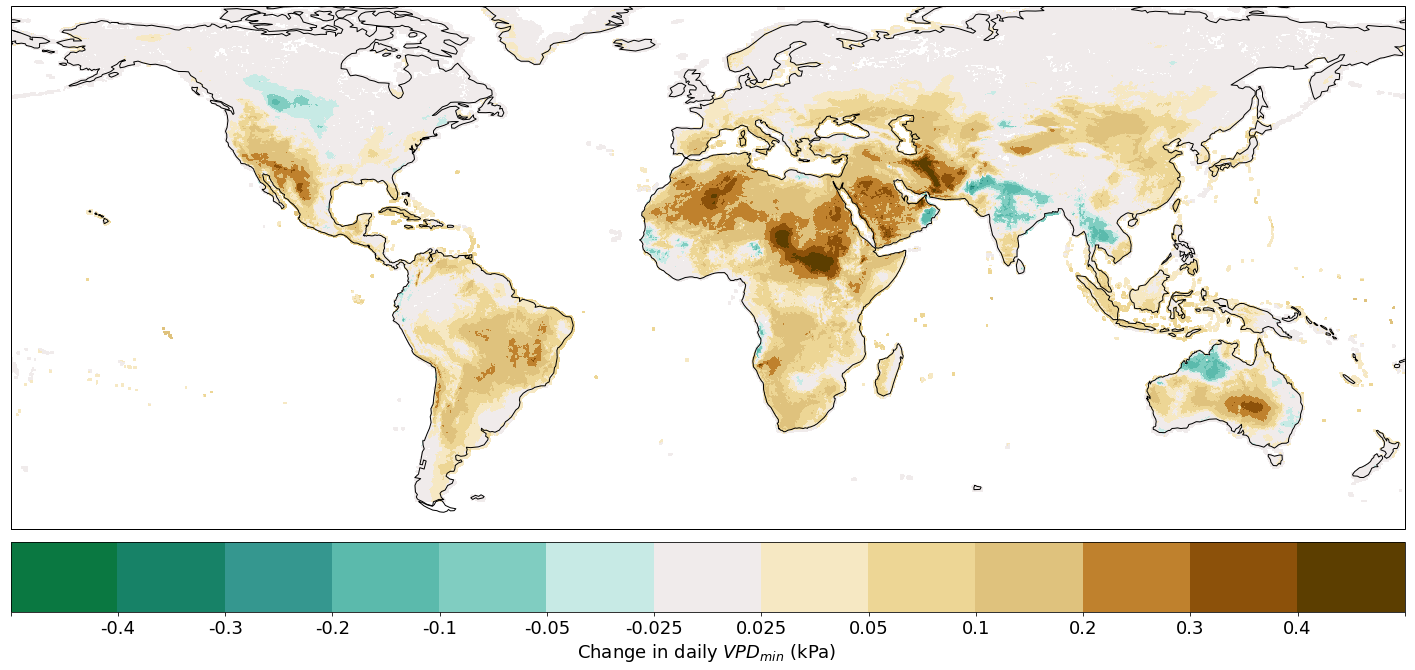

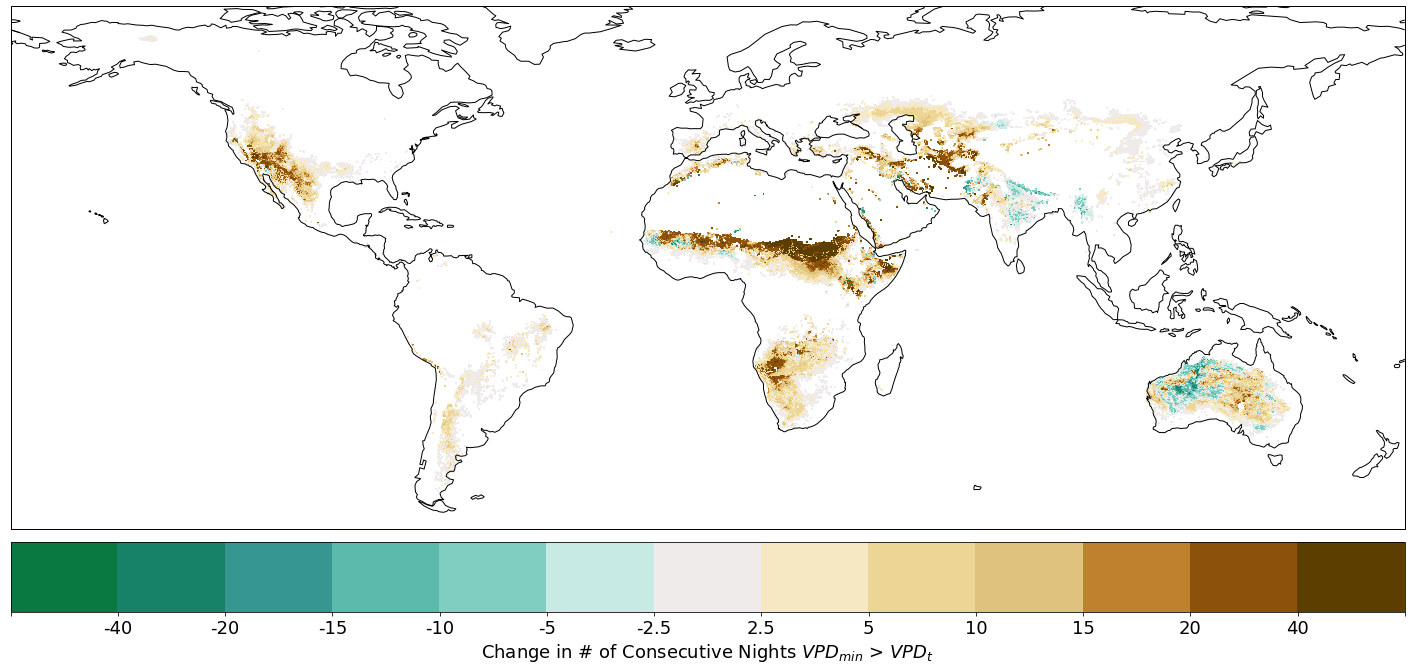

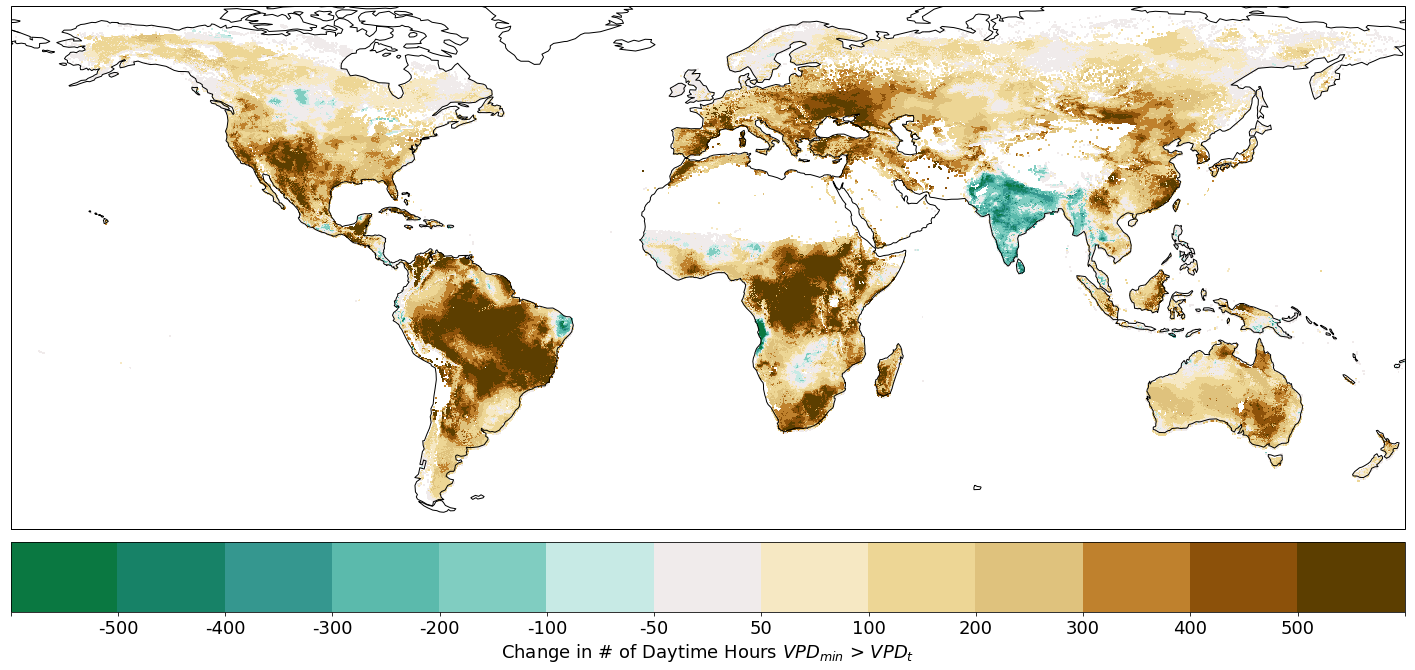

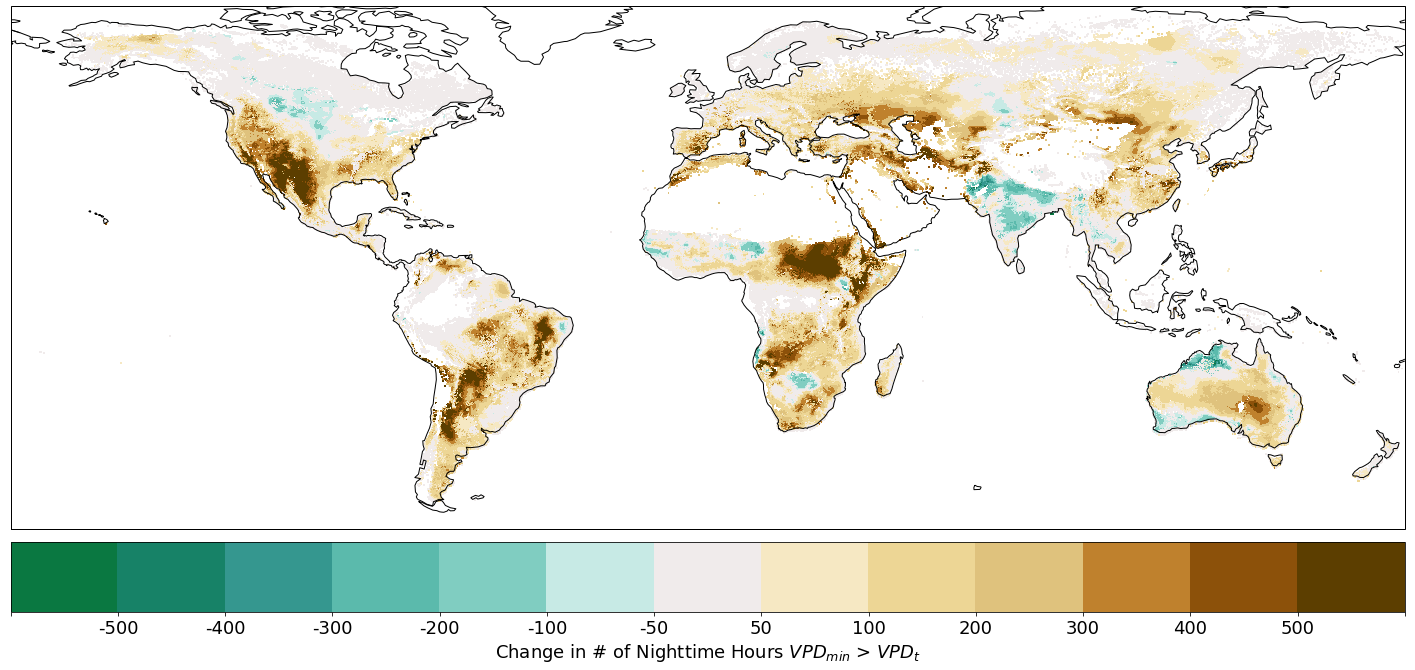

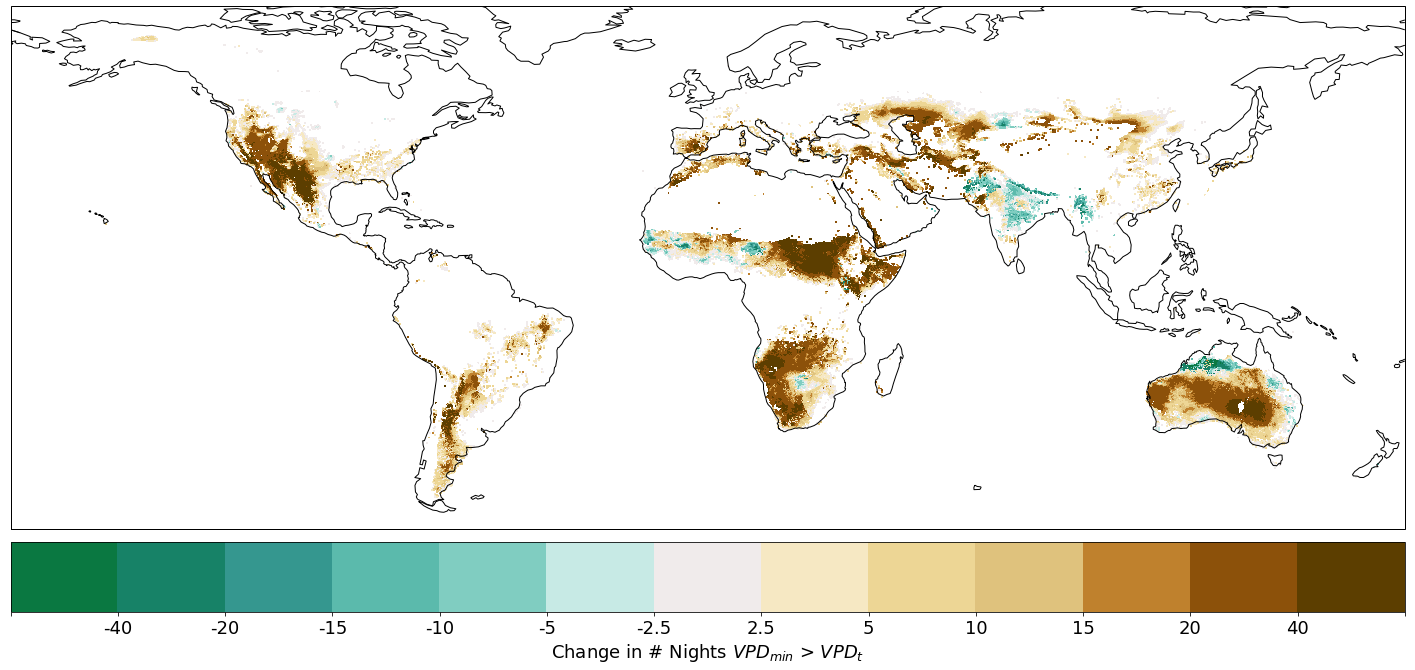

In [11]:
# bounds for files in glob
bounds_entries = [[-50,-25,-15,-10,-5,-2.5,2.5,5,10,15,25,50],
                  [-0.4,-0.3,-0.2,-0.1,-0.05, -0.025, 0.025, 0.05,0.1,0.2, 0.3, 0.4],
                  [-0.4,-0.3, -0.2,-0.1,-0.05, -0.025, 0.025, 0.05,0.1,0.2,0.3, 0.4],
                  [-40,-20,-15,-10,-5,-2.5,2.5,5,10,15,20,40],
                  [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500], 
                  [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500],
                  [-40,-20,-15,-10,-5,-2.5,2.5,5,10,15,20,40] ]

vpd_text = ('Annual Percent VPDmin Trend',
              'Annual VPDmin Trend',
              'Annual VPD Trend',
              'Consecutive Nights Trend',
              'Day Hours Trend',
              'Night Hours Trend',
              'Nights Trend' )

vpd_files2 = ['',
            '../fromJohn_Idaho_v3\\vpdmin_trend_19792020.nc',
            '',
            '../fromJohn_Idaho_v3\\connights_trend.nc',
             '../fromJohn_Idaho_v3\\dayhours_trend.nc',
              '../fromJohn_Idaho_v3\\nighthours_trend.nc',
             '../fromJohn_Idaho_v3\\nights_trend.nc']

vpd_text = (r'Percent change in daily $VPD_{min}$ (kPa)',
              r'Change in daily $VPD_{min}$ (kPa) ',
              'Change in daily VPD (kPA)',
              r'Change in # of Consecutive Nights $VPD_{min}$ > $VPD_t$',
              r'Change in # of Daytime Hours $VPD_{min}$ > $VPD_t$',
              r'Change in # of Nighttime Hours $VPD_{min}$ > $VPD_t$',
              r'Change in # Nights $VPD_{min}$ > $VPD_t$' )


r_folder = '../fromJohn_Idaho_v3/'
for f, b, t in zip(vpd_files2, bounds_entries, vpd_text):
    

    # check histogram for values
    
    if len(f) > 2:
        print(f)
#         with rio.open(f) as src:
#             vpd = src.read(1)
#             plt.hist(vpd.ravel(), bins=100)
#             plt.show()
        save_vpd_fig_GLDAS(f, b , raster_folder, None, t)
    else:
        continue

{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32768.0, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875)}
{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32768.0, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875)}
{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
{'driver': 

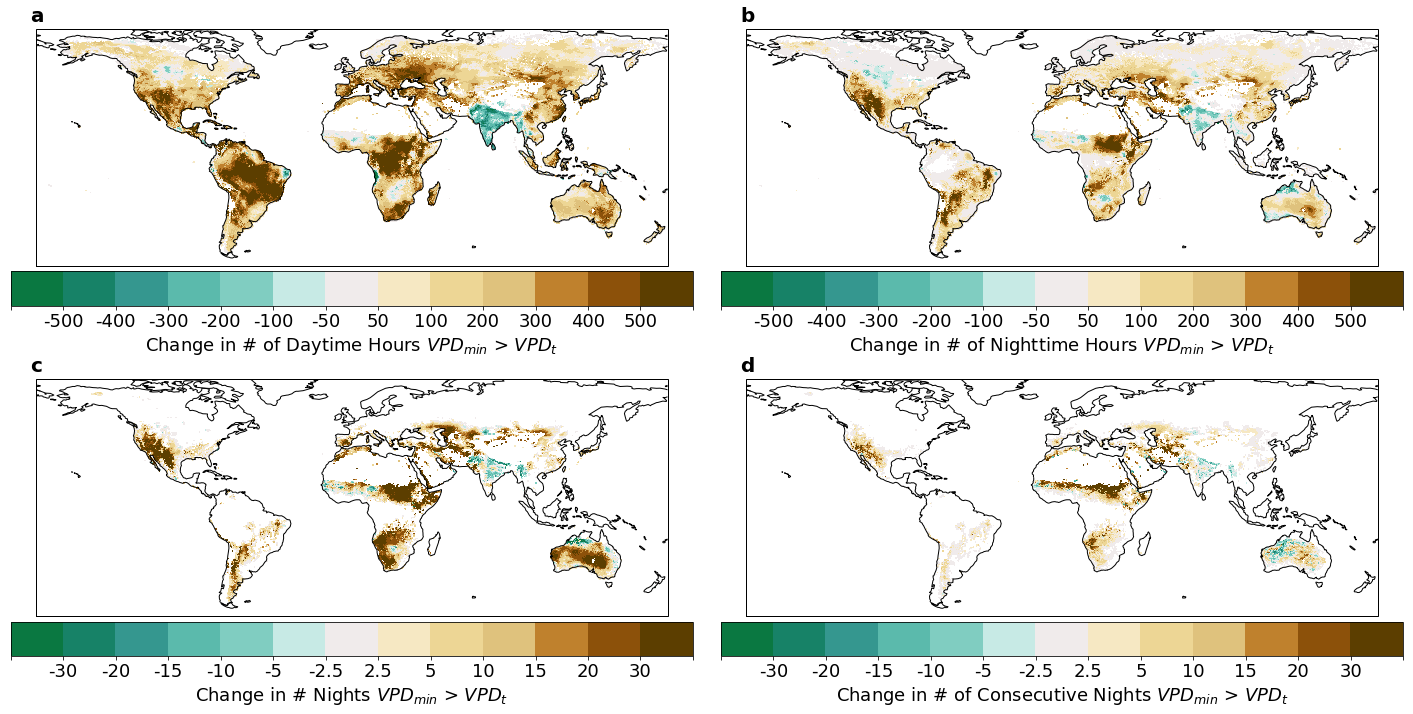

In [12]:
def save_vpd_fig_GLDAS_4x4(fnames, bounds_lists, raster_folder, gl,titles):
    
    font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

    matplotlib.rc('font', **font)

    # fig, ax = plt.subplots(1,1, projection=ccrs.PlateCarree(central_longitude=0))
    fig,((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(20,10), 
                                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
    
    caps = ('a', 'b', 'c', 'd')
    for ax, fname, bounds_list, title, cap in zip((ax1, ax2, ax3, ax4), fnames, bounds_lists, titles, caps):
    
        with rio.open(fname) as src:
            print(src.profile)
            vpd=src.read(1)

        vpd_data = vpd
        template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
        with rio.open(template) as src:
            meta = src.meta
            print(meta)

        o_tform = meta['transform']

        tform = o_tform.translation(-180,-15) * o_tform

        # dif_affine = np.array(meta['transform']) - [0, 0, 0, 0, 0, 0]
        # print(dif_affine)

        #num_x = meta['width']
        #num_y = meta['height']

        vnum_x = vpd_data.shape[1]
        vnum_y = vpd_data.shape[0]

        # incorporate aggregation factor
        vtlon = np.linspace(tform.c - tform.a, tform.c+vnum_x*tform.a, vnum_x)
        vtlat = np.linspace(tform.f - tform.e, tform.f+vnum_y*tform.e, vnum_y)
        vlon2d, vlat2d = np.meshgrid(vtlon, vtlat)

        # make data into xarray with location
        v_xdata = xr.DataArray(vpd_data, coords=[vtlat, vtlon], dims=['lat', 'lon'])
        v_xdata = xr.where(v_xdata == 0, np.nan, v_xdata)
        v_xdata = xr.where(v_xdata == -9999, np.nan, v_xdata)

        # incorporate GLDAS data
        v_xdata1 = v_xdata.copy()
        
        if 'vpdmin' in fname:
            v_xdata1 /= 10
        
        # work with the axes
        #ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
        ax.set_global()
        ax.coastlines()
        #ax.gridlines()


        colors = [(103,0,31),(178,24,43),(214,96,77),(232, 142, 111),
                  (244,165,130),(253,219,199),(240, 235, 235),(209,229,240),(146,197,222), (121, 181, 224),
                  (67,147,195),(33,102,172),(5,48,97)]

        colors = [(92, 62, 0),(140,81,10),(191,129,45),(223,194,125),
              (237, 214, 149), (246,232,195),(240, 235, 235),(199,234,229),(128,205,193),(91, 186, 172),
              (53,151,143),(23, 130, 103),(10, 120, 65)]

        colors = list(np.array(colors)/255)

        colors.reverse()
        cmap = matplotlib.colors.ListedColormap(colors)
        #bounds = [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500]
        bounds = bounds_list
        bounds_labels = [''] + bounds + ['']
        bounds = [-600] + bounds + [600]
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)

        # use the all the data
        #cf4 = v_xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')

        # use the gldas mask data
        cf4 = v_xdata1.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
        ax.set_ylim(-60, 75)

        # ax.set_title('NIGHTTIME %')

        cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                           boundaries=bounds, 
                           norm=norm, 
                           cmap=cmap,
                           ticks=bounds)
        cb4.set_ticklabels(bounds_labels)
        cb4.set_label(title)
        
        # add subplot label
        ax.text(-0.01, 1.03, cap, transform=ax.transAxes, 
            size=20, weight='bold')

        fig.tight_layout()
        fig_name = os.path.basename(fname).split('.')[0]
        
    plt.savefig(f'../fromJohn_Idaho_v3/change_daynights_4x4_GLDAS_mask.png')
    plt.show()

# plot 2x2 panel with a,b,c,d
# Change in annual number of 
# a) daytime hours; 
# b) nighttime hours (Fig. 4 reproduced here for ease of comparison); 
# c) nights; and 
# d) consecutive nights (1979-2019) where minimum VPD ≥ VPDt based on a linear trend across the burnable globe.

# entries 4,5,6,3

# bounds for files in glob
bounds_entries4x4 = [[-500,-400,-300,-200,-100,-50,50,100,200,300,400,500], 
                  [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500],
                  [-30,-20,-15,-10,-5,-2.5,2.5,5,10,15,20,30],
                 [-30,-20,-15,-10,-5,-2.5,2.5,5,10,15,20,30]]

vpd_text4x4 = (r'Change in # of Daytime Hours $VPD_{min}$ > $VPD_t$',
              r'Change in # of Nighttime Hours $VPD_{min}$ > $VPD_t$',
              r'Change in # Nights $VPD_{min}$ > $VPD_t$',
            r'Change in # of Consecutive Nights $VPD_{min}$ > $VPD_t$')

###################
# ('../fromJohn_Idaho\\dayhours19812010.nc',
#  '../fromJohn_Idaho\\dayhourstrend.nc',
#  '../fromJohn_Idaho\\days19812010.nc',
#  '../fromJohn_Idaho\\conseqnightstrend.nc')
vpd_4x4_files_ls = ('dayhours_climo19912020.nc',
                    'dayhours_trend.nc',
                    'nights_climo19912020.nc',
                    'connights_trend.nc')

vpd_files4x4 = [os.path.join('../fromJohn_Idaho_v3/', f) for f in vpd_4x4_files_ls]
######################

vpd_files4x4 = (vpd_files2[4], vpd_files2[5], vpd_files2[6], vpd_files2[3])

save_vpd_fig_GLDAS_4x4(vpd_files4x4, bounds_entries4x4, raster_folder, None, vpd_text4x4)

In [13]:
vpd_files2

['',
 '../fromJohn_Idaho_v3\\vpdmin_trend_19792020.nc',
 '',
 '../fromJohn_Idaho_v3\\connights_trend.nc',
 '../fromJohn_Idaho_v3\\dayhours_trend.nc',
 '../fromJohn_Idaho_v3\\nighthours_trend.nc',
 '../fromJohn_Idaho_v3\\nights_trend.nc']

['../fromJohn_Idaho_v3/dayhours_climo19912020.nc', '../fromJohn_Idaho_v3/nighthours_climo19912020.nc', '../fromJohn_Idaho_v3/nights_climo19912020.nc', '../fromJohn_Idaho_v3/connights_climo19912020.nc']


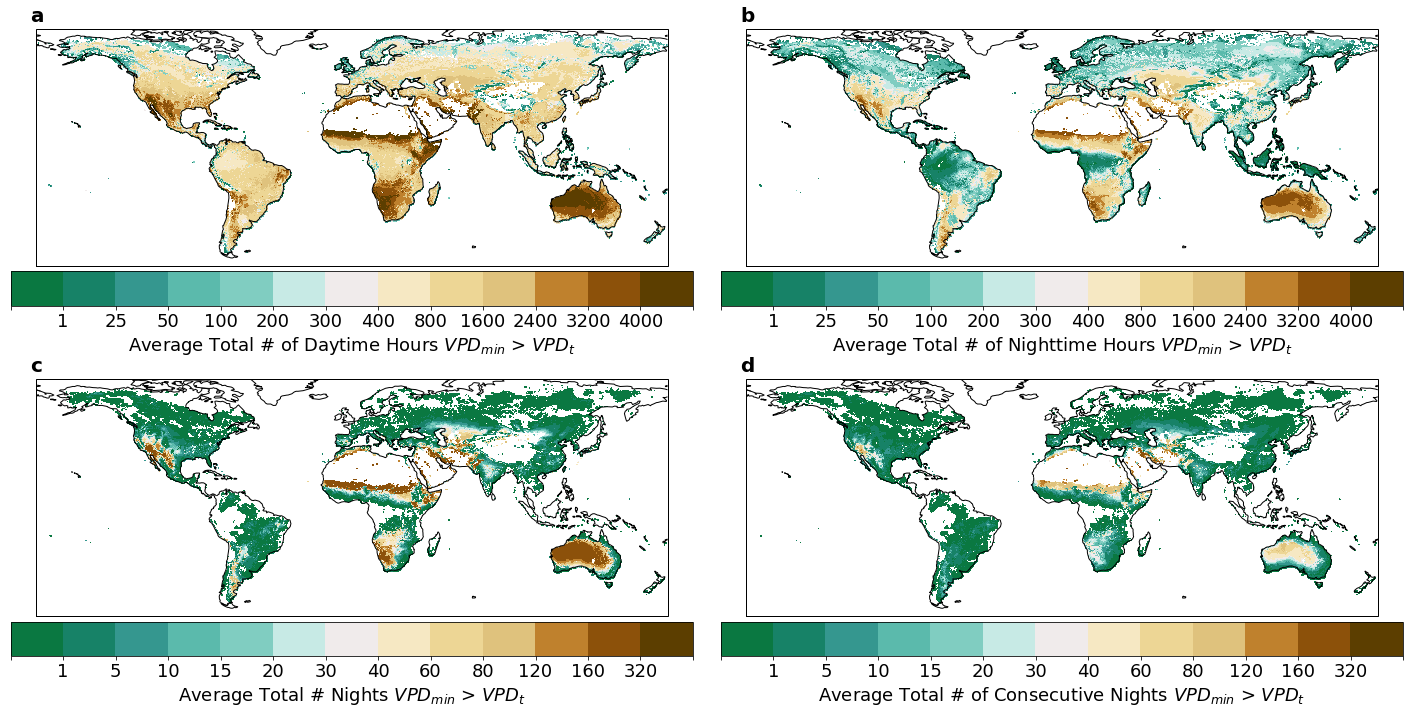

In [14]:
def save_vpd_fig_GLDAS_4x4_average(fnames, bounds_lists, raster_folder, gl,titles):
    
    font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

    matplotlib.rc('font', **font)

    # fig, ax = plt.subplots(1,1, projection=ccrs.PlateCarree(central_longitude=0))
    fig,((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(20,10), 
                                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
    
    caps = ('a', 'b', 'c', 'd')
    for ax, fname, bounds_list, title, cap in zip((ax1, ax2, ax3, ax4), fnames, bounds_lists, titles, caps):
    
        with rio.open(fname) as src:
            #print(src.profile)
            vpd=src.read(1)
            

        vpd_data = vpd
        template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
        with rio.open(template) as src:
            meta = src.meta
            #print(meta)

        o_tform = meta['transform']

        tform = o_tform.translation(-180,-15) * o_tform

        # dif_affine = np.array(meta['transform']) - [0, 0, 0, 0, 0, 0]
        # print(dif_affine)

        #num_x = meta['width']
        #num_y = meta['height']

        vnum_x = vpd_data.shape[1]
        vnum_y = vpd_data.shape[0]

        # incorporate aggregation factor
        vtlon = np.linspace(tform.c - tform.a, tform.c+vnum_x*tform.a, vnum_x)
        vtlat = np.linspace(tform.f - tform.e, tform.f+vnum_y*tform.e, vnum_y)
        vlon2d, vlat2d = np.meshgrid(vtlon, vtlat)

        # make data into xarray with location
        v_xdata = xr.DataArray(vpd_data, coords=[vtlat, vtlon], dims=['lat', 'lon'])
        v_xdata = xr.where(v_xdata == 0, np.nan, v_xdata)
        v_xdata = xr.where(v_xdata == -9999, np.nan, v_xdata)

        # incorporate GLDAS data
        v_xdata1 = v_xdata.copy()
        
        if 'vpdmin' in fname:
            v_xdata1 /= 10
        
        # work with the axes
        #ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
        ax.set_global()
        ax.coastlines()
        #ax.gridlines()


        colors = [(103,0,31),(178,24,43),(214,96,77),(232, 142, 111),
                  (244,165,130),(253,219,199),(240, 235, 235),(209,229,240),(146,197,222), (121, 181, 224),
                  (67,147,195),(33,102,172),(5,48,97)]

        colors = [(92, 62, 0),(140,81,10),(191,129,45),(223,194,125),
              (237, 214, 149), (246,232,195),(240, 235, 235),(199,234,229),(128,205,193),(91, 186, 172),
              (53,151,143),(23, 130, 103),(10, 120, 65)]

        colors = list(np.array(colors)/255)

        colors.reverse()
        cmap = matplotlib.colors.ListedColormap(colors)
        #bounds = [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500]
        bounds = bounds_list
        bounds_labels = [''] + bounds + ['']
        bounds = [-6000] + bounds + [6000]
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)

        # use the all the data
        #cf4 = v_xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')

        # use the gldas mask data
        cf4 = v_xdata1.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
        ax.set_ylim(-60, 75)

        # ax.set_title('NIGHTTIME %')

        cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                           boundaries=bounds, 
                           norm=norm, 
                           cmap=cmap,
                           ticks=bounds)
        cb4.set_ticklabels(bounds_labels)
        cb4.set_label(title)
        
        # add subplot label
        ax.text(-0.01, 1.03, cap, transform=ax.transAxes, 
            size=20, weight='bold')

        fig.tight_layout()
        fig_name = os.path.basename(fname).split('.')[0]
        
    plt.savefig(f'../fromJohn_Idaho_v3/change_daynights_AVG_4x4_GLDAS_mask.png')
    plt.show()

# plot 2x2 panel with a,b,c,d
# The average total 
# a) daytime hours; 
# b) nighttime hours; 
# c) nights (days, 24-hour periods, when VPDmin ≥ VPDt); and 
# d) consecutive nights per year (1981-2010) where minimum VPD ≥ VPDt across the burnable globe.

vpd_text4x4 = (r'Average Total # of Daytime Hours $VPD_{min}$ > $VPD_t$',
              r'Average Total # of Nighttime Hours $VPD_{min}$ > $VPD_t$',
              r'Average Total # Nights $VPD_{min}$ > $VPD_t$',
            r'Average Total # of Consecutive Nights $VPD_{min}$ > $VPD_t$')

# bounds for files in glob
hours_bounds = [1, 25, 50, 100, 200, 300, 400, 800, 1600, 2400, 3200, 4000]
days_bounds = [1, 5, 10, 15, 20, 30, 40, 60, 80, 120, 160, 320]
bounds_entries4x4 = [hours_bounds, hours_bounds, days_bounds, days_bounds]



vpd_4x4_files_ls = ('dayhours_climo19912020.nc',
                    'nighthours_climo19912020.nc',
                    'nights_climo19912020.nc',
                    'connights_climo19912020.nc')

vpd_files4x4 = [os.path.join('../fromJohn_Idaho_v3/', f) for f in vpd_4x4_files_ls]

print(vpd_files4x4)
save_vpd_fig_GLDAS_4x4_average(vpd_files4x4, bounds_entries4x4, raster_folder, None, vpd_text4x4)

make a big figure, 2x4, combining both previous figures

['../fromJohn_Idaho_v3/dayhours_climo19912020.nc', '../fromJohn_Idaho_v3/nighthours_climo19912020.nc', '../fromJohn_Idaho_v3/nights_climo19912020.nc', '../fromJohn_Idaho_v3/connights_climo19912020.nc', '../fromJohn_Idaho_v3\\dayhours_trend.nc', '../fromJohn_Idaho_v3\\nighthours_trend.nc', '../fromJohn_Idaho_v3\\nights_trend.nc', '../fromJohn_Idaho_v3\\connights_trend.nc']


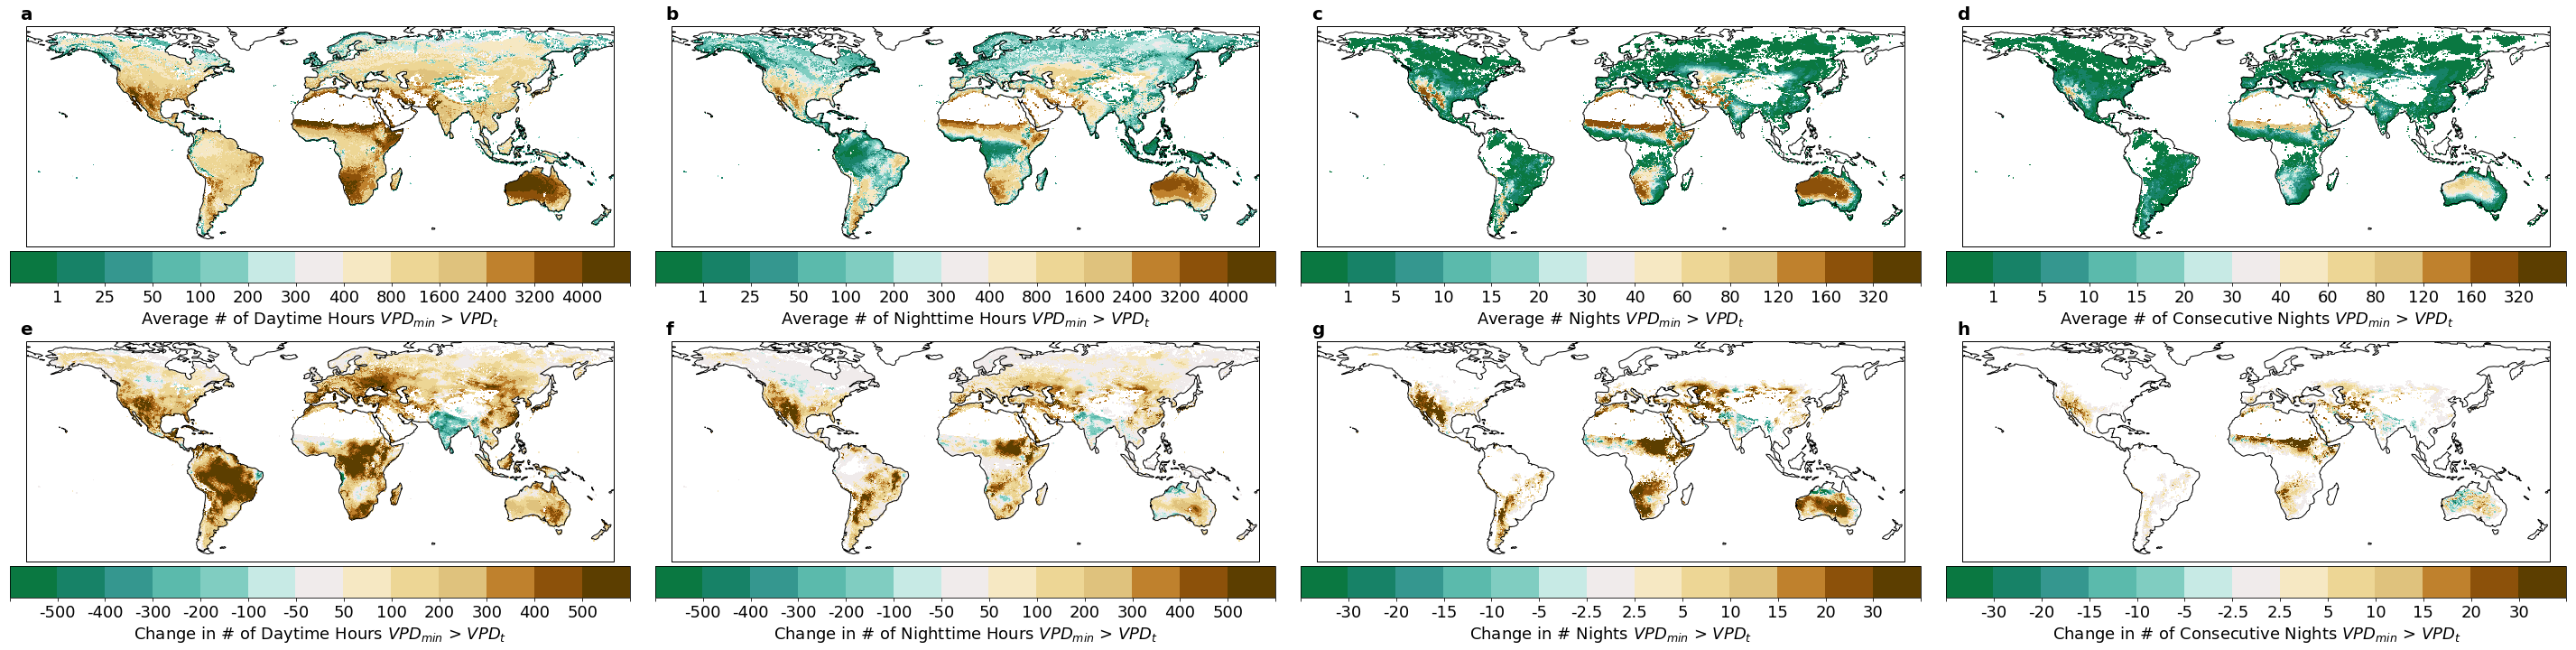

In [15]:
def save_vpd_fig_GLDAS_2x4(fnames, bounds_lists, raster_folder, gl,titles):
    
    font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

    matplotlib.rc('font', **font)

    # fig, ax = plt.subplots(1,1, projection=ccrs.PlateCarree(central_longitude=0))
    fig,((ax1, ax2, ax3,ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(40,10), 
                                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
    
    caps = ('a', 'b', 'c', 'd','e', 'f', 'g', 'h')
    for ax, fname, bounds_list, title, cap in zip((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8), fnames, bounds_lists, titles, caps):
    
        with rio.open(fname) as src:
            #print(src.profile)
            vpd=src.read(1)
            

        vpd_data = vpd
        template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
        with rio.open(template) as src:
            meta = src.meta
            #print(meta)

        o_tform = meta['transform']

        tform = o_tform.translation(-180,-15) * o_tform

        # dif_affine = np.array(meta['transform']) - [0, 0, 0, 0, 0, 0]
        # print(dif_affine)

        #num_x = meta['width']
        #num_y = meta['height']

        vnum_x = vpd_data.shape[1]
        vnum_y = vpd_data.shape[0]

        # incorporate aggregation factor
        vtlon = np.linspace(tform.c - tform.a, tform.c+vnum_x*tform.a, vnum_x)
        vtlat = np.linspace(tform.f - tform.e, tform.f+vnum_y*tform.e, vnum_y)
        vlon2d, vlat2d = np.meshgrid(vtlon, vtlat)

        # make data into xarray with location
        v_xdata = xr.DataArray(vpd_data, coords=[vtlat, vtlon], dims=['lat', 'lon'])
        v_xdata = xr.where(v_xdata == 0, np.nan, v_xdata)
        v_xdata = xr.where(v_xdata == -9999, np.nan, v_xdata)

        # incorporate GLDAS data
        v_xdata1 = v_xdata.copy()
        
        if 'vpdmin' in fname:
            v_xdata1 /= 10
        
        # work with the axes
        #ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
        ax.set_global()
        ax.coastlines()
        #ax.gridlines()


        colors = [(103,0,31),(178,24,43),(214,96,77),(232, 142, 111),
                  (244,165,130),(253,219,199),(240, 235, 235),(209,229,240),(146,197,222), (121, 181, 224),
                  (67,147,195),(33,102,172),(5,48,97)]

        colors = [(92, 62, 0),(140,81,10),(191,129,45),(223,194,125),
              (237, 214, 149), (246,232,195),(240, 235, 235),(199,234,229),(128,205,193),(91, 186, 172),
              (53,151,143),(23, 130, 103),(10, 120, 65)]

        colors = list(np.array(colors)/255)

        colors.reverse()
        cmap = matplotlib.colors.ListedColormap(colors)
        #bounds = [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500]
        bounds = bounds_list
        bounds_labels = [''] + bounds + ['']
        bounds = [-6000] + bounds + [6000]
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)

        # use the all the data
        #cf4 = v_xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')

        # use the gldas mask data
        cf4 = v_xdata1.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
        ax.set_ylim(-60, 75)

        # ax.set_title('NIGHTTIME %')

        cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                           boundaries=bounds, 
                           norm=norm, 
                           cmap=cmap,
                           ticks=bounds)
        cb4.set_ticklabels(bounds_labels)
        cb4.set_label(title)
        
        # add subplot label
        ax.text(-0.01, 1.03, cap, transform=ax.transAxes, 
            size=20, weight='bold')

        fig.tight_layout()
        fig_name = os.path.basename(fname).split('.')[0]
        
    plt.savefig(f'../fromJohn_Idaho_v3/EDF_climate_figure.png')
    plt.show()

# plot 2x2 panel with a,b,c,d, e, f, g, h

# plot 2x2 panel with a,b,c,d
# Change in annual number of 
# a) daytime hours; 
# b) nighttime hours (Fig. 4 reproduced here for ease of comparison); 
# c) nights; and 
# d) consecutive nights (1979-2019) where minimum VPD ≥ VPDt based on a linear trend across the burnable globe.

# The average total 
# e) daytime hours; 
# f) nighttime hours; 
# g) nights (days, 24-hour periods, when VPDmin ≥ VPDt); and 
# h) consecutive nights per year (1981-2010) where minimum VPD ≥ VPDt across the burnable globe.

# entries 0,3,1,2

vpd_text4x4 = (  r'Average # of Daytime Hours $VPD_{min}$ > $VPD_t$',
              r'Average # of Nighttime Hours $VPD_{min}$ > $VPD_t$',
              r'Average # Nights $VPD_{min}$ > $VPD_t$',
            r'Average # of Consecutive Nights $VPD_{min}$ > $VPD_t$',
               
               r'Change in # of Daytime Hours $VPD_{min}$ > $VPD_t$',
              r'Change in # of Nighttime Hours $VPD_{min}$ > $VPD_t$',
              r'Change in # Nights $VPD_{min}$ > $VPD_t$',
            r'Change in # of Consecutive Nights $VPD_{min}$ > $VPD_t$')

vpd_4x4_files_ls = ('dayhours_climo19912020.nc',
                    'nighthours_climo19912020.nc',
                    'nights_climo19912020.nc',
                    'connights_climo19912020.nc')

vpd_files4x4 = [os.path.join('../fromJohn_Idaho_v3/', f) for f in vpd_4x4_files_ls]

# bounds for files in glob
hours_bounds = [1, 25, 50, 100, 200, 300, 400, 800, 1600, 2400, 3200, 4000]
days_bounds = [1, 5, 10, 15, 20, 30, 40, 60, 80, 120, 160, 320]
bounds_entries4x4 = [hours_bounds, hours_bounds, days_bounds, days_bounds]


vpd_files4x4 += [vpd_files2[4], vpd_files2[5], vpd_files2[6], vpd_files2[3]]
# bounds for files in glob
bounds_entries4x4 += [[-500,-400,-300,-200,-100,-50,50,100,200,300,400,500], 
                  [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500],
                  [-30,-20,-15,-10,-5,-2.5,2.5,5,10,15,20,30],
                 [-30,-20,-15,-10,-5,-2.5,2.5,5,10,15,20,30]]




print(vpd_files4x4)
save_vpd_fig_GLDAS_2x4(vpd_files4x4, bounds_entries4x4, raster_folder, None, vpd_text4x4)

['../fromJohn_Idaho_v3/dayhours_climo19912020.nc', '../fromJohn_Idaho_v3/nighthours_climo19912020.nc', '../fromJohn_Idaho_v3/nights_climo19912020.nc', '../fromJohn_Idaho_v3/connights_climo19912020.nc', '../fromJohn_Idaho_v3\\dayhours_trend.nc', '../fromJohn_Idaho_v3\\nighthours_trend.nc', '../fromJohn_Idaho_v3\\nights_trend.nc', '../fromJohn_Idaho_v3\\connights_trend.nc']


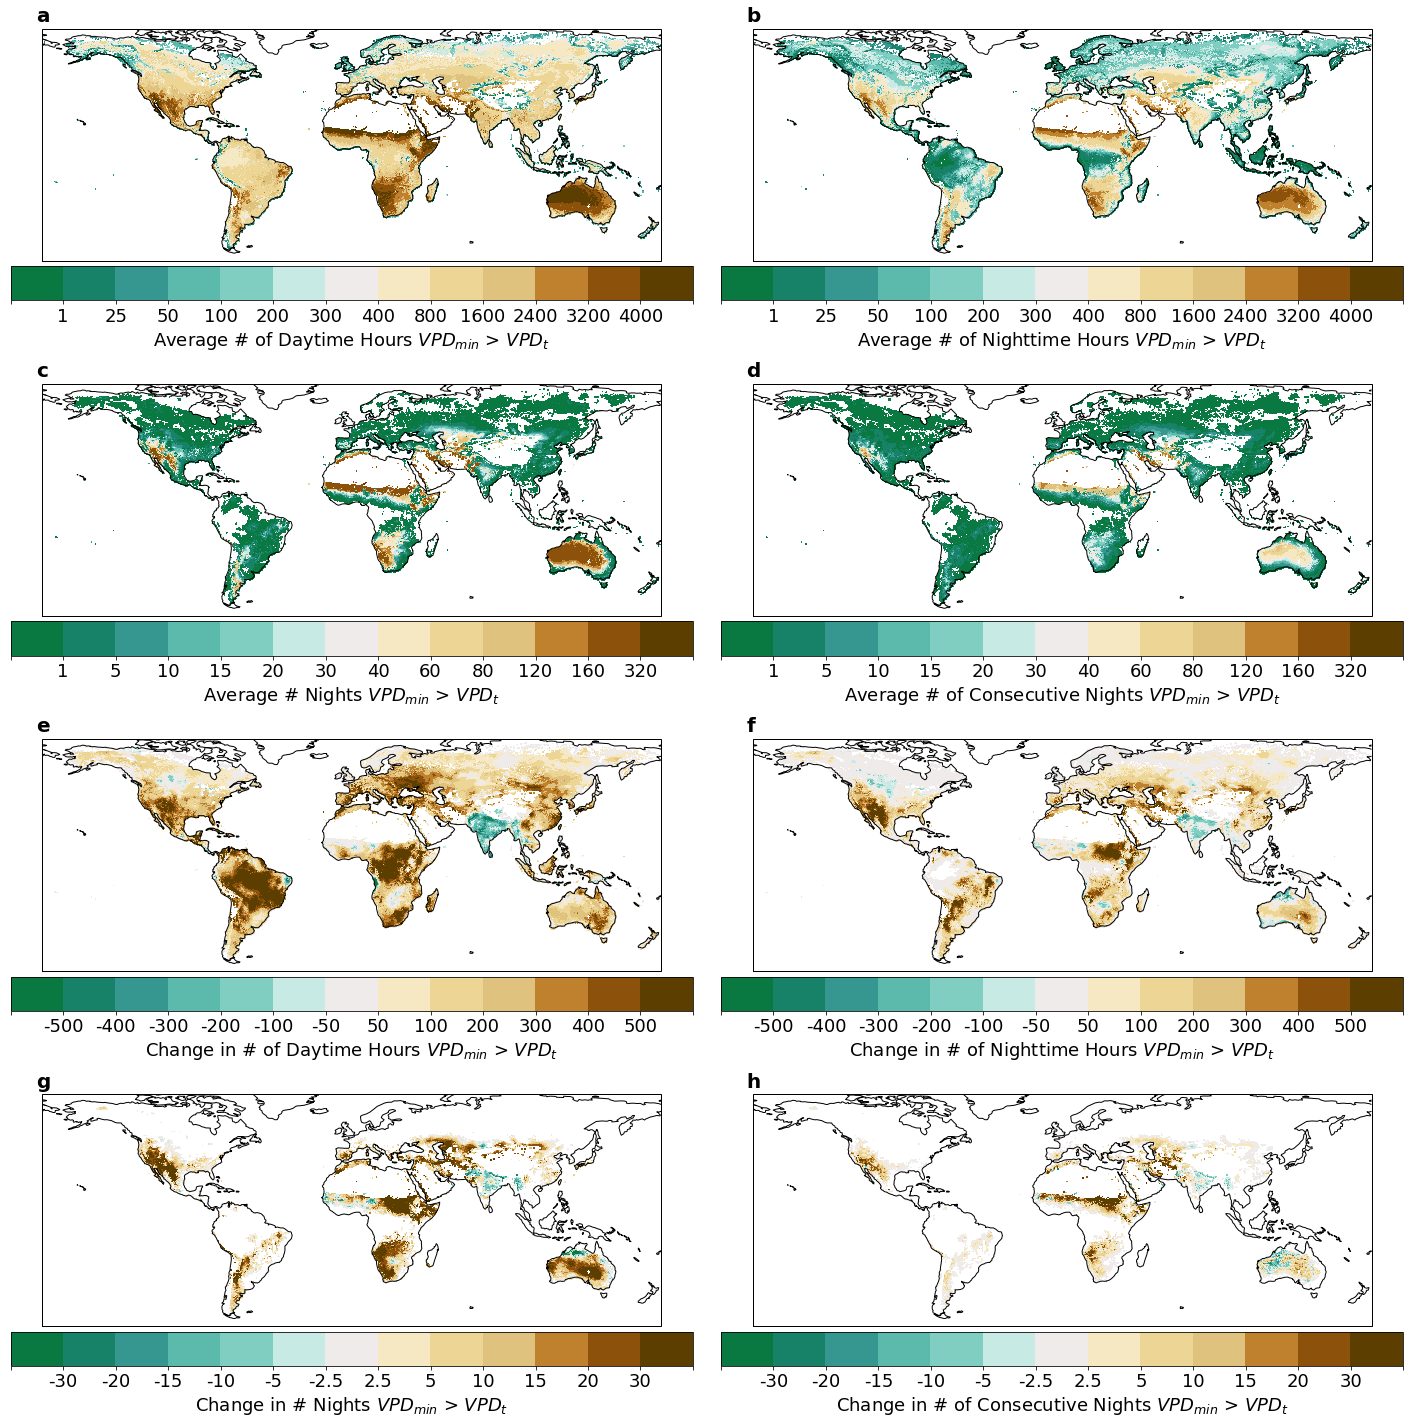

In [16]:
def save_vpd_fig_GLDAS_4x2(fnames, bounds_lists, raster_folder, gl,titles):
    
    font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

    matplotlib.rc('font', **font)

    # fig, ax = plt.subplots(1,1, projection=ccrs.PlateCarree(central_longitude=0))
    fig,((ax1, ax2), (ax3,ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(20,20), 
                                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
    
    caps = ('a', 'b', 'c', 'd','e', 'f', 'g', 'h')
    for ax, fname, bounds_list, title, cap in zip((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8), fnames, bounds_lists, titles, caps):
    
        with rio.open(fname) as src:
            #print(src.profile)
            vpd=src.read(1)
            

        vpd_data = vpd
        template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
        with rio.open(template) as src:
            meta = src.meta
            #print(meta)

        o_tform = meta['transform']

        tform = o_tform.translation(-180,-15) * o_tform

        # dif_affine = np.array(meta['transform']) - [0, 0, 0, 0, 0, 0]
        # print(dif_affine)

        #num_x = meta['width']
        #num_y = meta['height']

        vnum_x = vpd_data.shape[1]
        vnum_y = vpd_data.shape[0]

        # incorporate aggregation factor
        vtlon = np.linspace(tform.c - tform.a, tform.c+vnum_x*tform.a, vnum_x)
        vtlat = np.linspace(tform.f - tform.e, tform.f+vnum_y*tform.e, vnum_y)
        vlon2d, vlat2d = np.meshgrid(vtlon, vtlat)

        # make data into xarray with location
        v_xdata = xr.DataArray(vpd_data, coords=[vtlat, vtlon], dims=['lat', 'lon'])
        v_xdata = xr.where(v_xdata == 0, np.nan, v_xdata)
        v_xdata = xr.where(v_xdata == -9999, np.nan, v_xdata)

        # incorporate GLDAS data
        v_xdata1 = v_xdata.copy()
        
        if 'vpdmin' in fname:
            v_xdata1 /= 10
        
        # work with the axes
        #ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
        ax.set_global()
        ax.coastlines()
        #ax.gridlines()


        colors = [(103,0,31),(178,24,43),(214,96,77),(232, 142, 111),
                  (244,165,130),(253,219,199),(240, 235, 235),(209,229,240),(146,197,222), (121, 181, 224),
                  (67,147,195),(33,102,172),(5,48,97)]

        colors = [(92, 62, 0),(140,81,10),(191,129,45),(223,194,125),
              (237, 214, 149), (246,232,195),(240, 235, 235),(199,234,229),(128,205,193),(91, 186, 172),
              (53,151,143),(23, 130, 103),(10, 120, 65)]

        colors = list(np.array(colors)/255)

        colors.reverse()
        cmap = matplotlib.colors.ListedColormap(colors)
        #bounds = [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500]
        bounds = bounds_list
        bounds_labels = [''] + bounds + ['']
        bounds = [-6000] + bounds + [6000]
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)

        # use the all the data
        #cf4 = v_xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')

        # use the gldas mask data
        cf4 = v_xdata1.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
        ax.set_ylim(-60, 75)

        # ax.set_title('NIGHTTIME %')

        cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                           boundaries=bounds, 
                           norm=norm, 
                           cmap=cmap,
                           ticks=bounds)
        cb4.set_ticklabels(bounds_labels)
        cb4.set_label(title)
        
        # add subplot label
        ax.text(-0.01, 1.03, cap, transform=ax.transAxes, 
            size=20, weight='bold')

        fig.tight_layout()
        fig_name = os.path.basename(fname).split('.')[0]
        
    plt.savefig(f'../fromJohn_Idaho_v3/EDF_climate_figure_vertical.png')
    plt.show()

# plot 2x2 panel with a,b,c,d, e, f, g, h

# plot 2x2 panel with a,b,c,d
# Change in annual number of 
# a) daytime hours; 
# b) nighttime hours (Fig. 4 reproduced here for ease of comparison); 
# c) nights; and 
# d) consecutive nights (1979-2019) where minimum VPD ≥ VPDt based on a linear trend across the burnable globe.

# The average total 
# e) daytime hours; 
# f) nighttime hours; 
# g) nights (days, 24-hour periods, when VPDmin ≥ VPDt); and 
# h) consecutive nights per year (1981-2010) where minimum VPD ≥ VPDt across the burnable globe.

# entries 0,3,1,2

vpd_text4x4 = (  r'Average # of Daytime Hours $VPD_{min}$ > $VPD_t$',
              r'Average # of Nighttime Hours $VPD_{min}$ > $VPD_t$',
              r'Average # Nights $VPD_{min}$ > $VPD_t$',
            r'Average # of Consecutive Nights $VPD_{min}$ > $VPD_t$',
               
               r'Change in # of Daytime Hours $VPD_{min}$ > $VPD_t$',
              r'Change in # of Nighttime Hours $VPD_{min}$ > $VPD_t$',
              r'Change in # Nights $VPD_{min}$ > $VPD_t$',
            r'Change in # of Consecutive Nights $VPD_{min}$ > $VPD_t$')

vpd_4x4_files_ls = ('dayhours_climo19912020.nc',
                    'nighthours_climo19912020.nc',
                    'nights_climo19912020.nc',
                    'connights_climo19912020.nc')

vpd_files4x4 = [os.path.join('../fromJohn_Idaho_v3/', f) for f in vpd_4x4_files_ls]

# bounds for files in glob
hours_bounds = [1, 25, 50, 100, 200, 300, 400, 800, 1600, 2400, 3200, 4000]
days_bounds = [1, 5, 10, 15, 20, 30, 40, 60, 80, 120, 160, 320]
bounds_entries4x4 = [hours_bounds, hours_bounds, days_bounds, days_bounds]


vpd_files4x4 += [vpd_files2[4], vpd_files2[5], vpd_files2[6], vpd_files2[3]]
# bounds for files in glob
bounds_entries4x4 += [[-500,-400,-300,-200,-100,-50,50,100,200,300,400,500], 
                  [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500],
                  [-30,-20,-15,-10,-5,-2.5,2.5,5,10,15,20,30],
                 [-30,-20,-15,-10,-5,-2.5,2.5,5,10,15,20,30]]




print(vpd_files4x4)
save_vpd_fig_GLDAS_4x2(vpd_files4x4, bounds_entries4x4, raster_folder, None, vpd_text4x4)

In [17]:
some_dict = {}
for k,v in zip([os.path.basename(_).split('.')[0] for _ in vpd_files], bounds_entries):
    some_dict[k]=v
    
# some_dict

In [18]:
for f in vpd_files:
    with rio.open(f) as src:
        a = src.read()
        print(a.min(), a.max())

0.0 202.56667
-47.6 118.36364
-9999.0 4814.933
-9999.0 1705.2
-9999.0 3985.8333
-9999.0 1224.0
0.0 355.0
-67.84615 189.0
-3.4042106 6.423529


make the line plot

In [19]:
vpd_tm = pd.read_csv('../fromJohn_Idaho_v3/globalhours.csv')
vpd_tm.head()

year  nighthours  dayhours
0  1979      561.85    1361.6
1  1980      598.46    1406.0
2  1981      562.60    1373.9
3  1982      565.67    1354.6
4  1983      588.42    1388.3

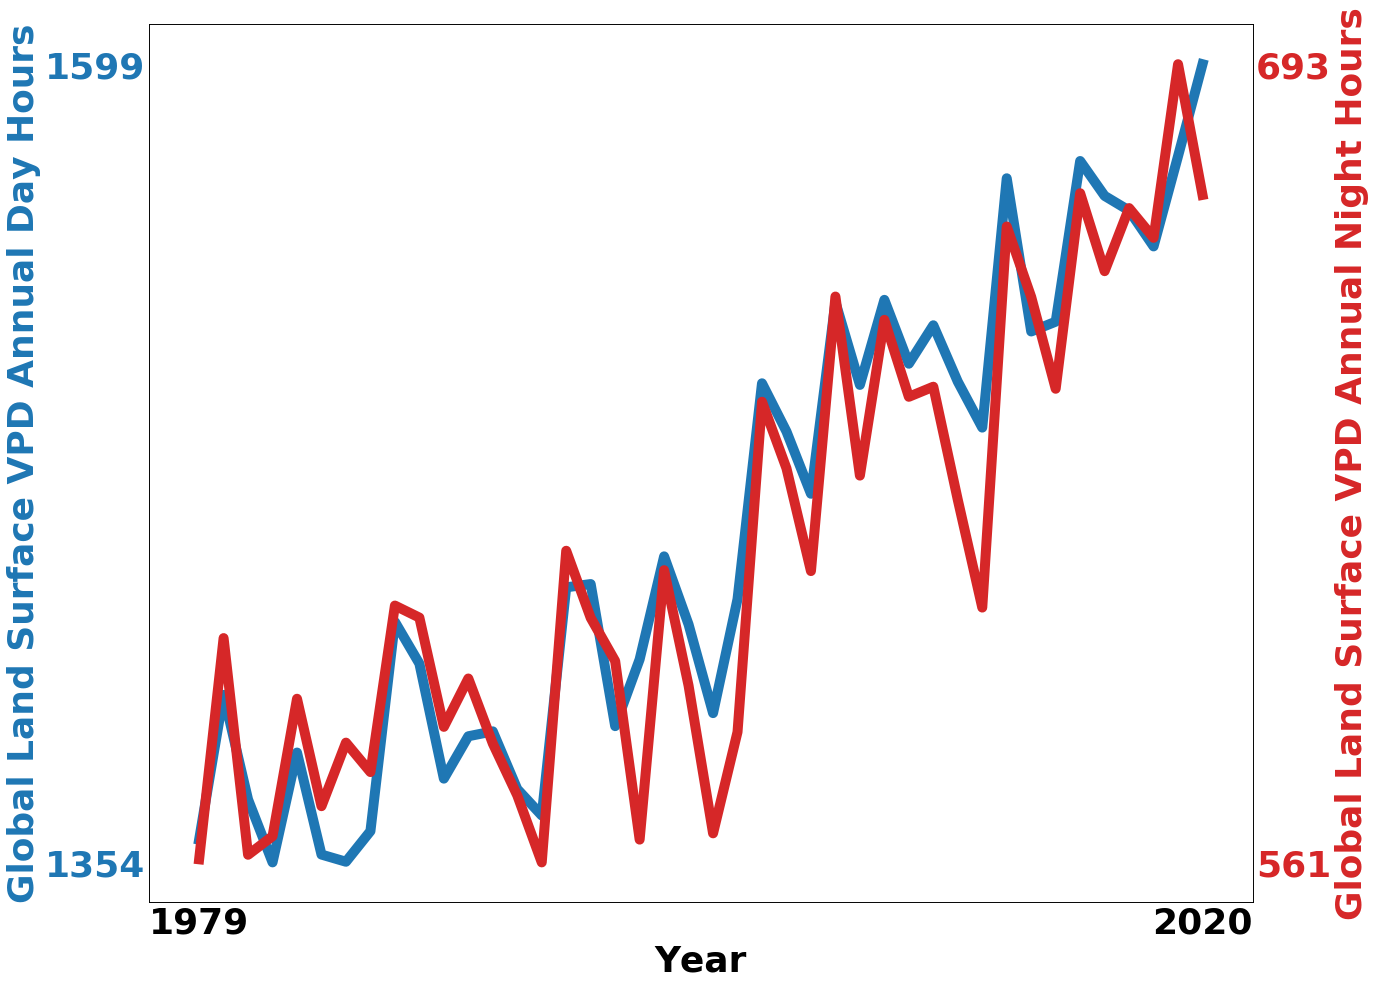

In [20]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 36}

matplotlib.rc('font', **font)

fig, ax1 = plt.subplots(figsize=(20,15))
t = vpd_tm['year']
data1 = vpd_tm['nighthours']
data2 = vpd_tm['dayhours']

lw = 10

color = 'tab:blue'
ax1.set_xlabel('Year', weight='bold')
ax1.set_ylabel('Global Land Surface VPD Annual Day Hours', color=color, weight='bold')
ax1.plot(t, data2, color=color, linewidth=lw)
ax1.set_xticks(t)

# set the y ticks
ax1.set_yticks(data2.sort_values())
top = -1
bottom = 0
my_yticks = ax1.get_yticks()
new_yticks = ['' for _ in my_yticks]
new_yticks[top] = int(my_yticks[top])
new_yticks[bottom] = int(my_yticks[bottom])
ax1.set_yticklabels(new_yticks)

ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(length=0)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Global Land Surface VPD Annual Night Hours', color=color, weight='bold')  # we already handled the x-label with ax1
ax2.plot(t, data1, color=color, linewidth=lw)
ax2.set_xticklabels([''])
ax2.tick_params(axis='y', labelcolor=color, length=0)

# set the y ticks
ax2.set_yticks(data1.sort_values())
top = -1
bottom = 0
my_yticks = ax2.get_yticks()
new_yticks = ['' for _ in my_yticks]
new_yticks[top] = int(my_yticks[top])
new_yticks[bottom] = int(my_yticks[bottom])
ax2.set_yticklabels(new_yticks)

# set the xticks
my_xticks = ax2.get_xticks()
new_xticks = ['' for _ in my_xticks]
left = 0
right = -1
new_xticks[left] = my_xticks[left]
new_xticks[right] = my_xticks[right]
ax2.set_xticklabels(new_xticks)
# ax2.tick_params(axis=u'both', which=u'both',length=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('../fromJohn_Idaho_v3/vpd_hours_lineplot.png')
plt.show()

# try with inset

In [21]:
vpd_files2[-5]
vpd_files[-5]
vpd_files2

['',
 '../fromJohn_Idaho_v3\\vpdmin_trend_19792020.nc',
 '',
 '../fromJohn_Idaho_v3\\connights_trend.nc',
 '../fromJohn_Idaho_v3\\dayhours_trend.nc',
 '../fromJohn_Idaho_v3\\nighthours_trend.nc',
 '../fromJohn_Idaho_v3\\nights_trend.nc']

{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32768.0, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875)}


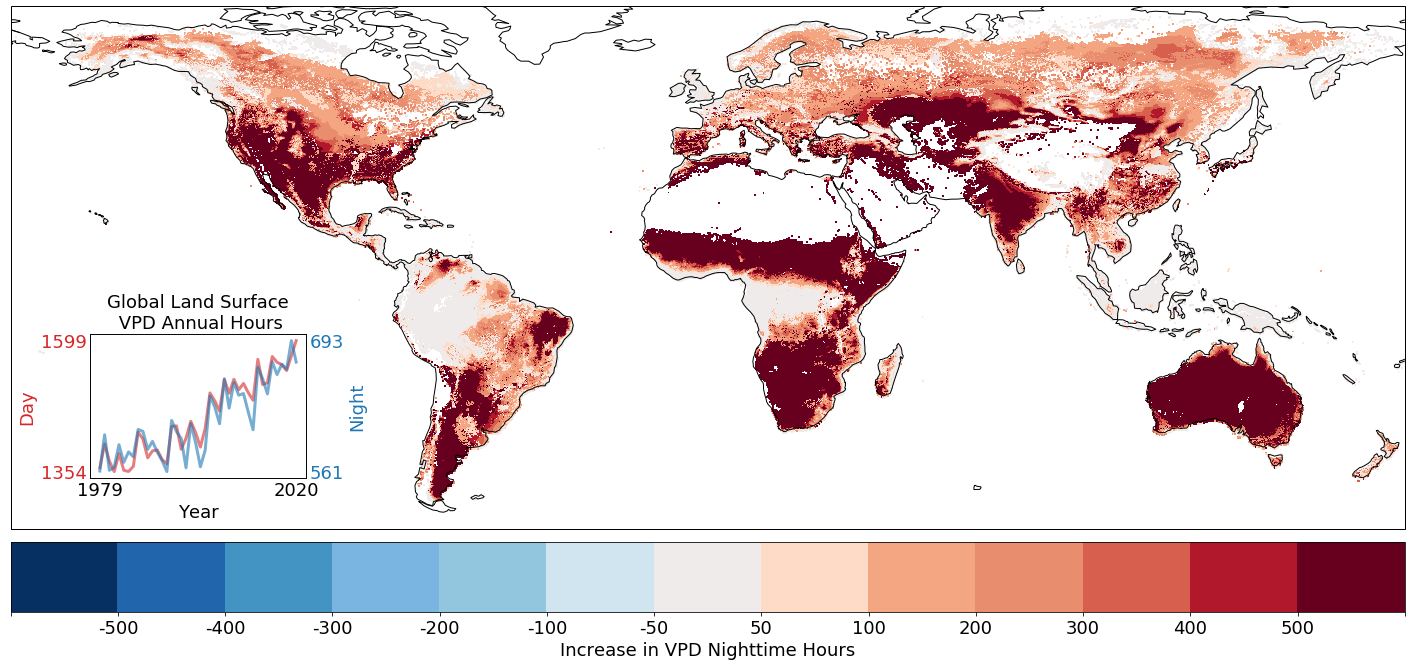

In [22]:

    
font = {'family' : 'normal',
    'weight' : 'medium',
    'size'   : 18}

matplotlib.rc('font', **font)

# using nighthours_trend2003 from the data refresh, but the same bounds_entries
fname, bounds_list = vpd_files2[-5], bounds_entries[-2]
fname = '../fromJohn_Idaho_v3/nighthours_climo19912020.nc'
with rio.open(fname) as src:
    print(src.profile)
    vpd=src.read(1)



vpd_data = vpd
template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
with rio.open(template) as src:
    meta = src.meta
    print(meta)

o_tform = meta['transform']

tform = o_tform.translation(-180,-15) * o_tform

# dif_affine = np.array(meta['transform']) - [0, 0, 0, 0, 0, 0]
# print(dif_affine)

#num_x = meta['width']
#num_y = meta['height']

vnum_x = vpd_data.shape[1]
vnum_y = vpd_data.shape[0]

# incorporate aggregation factor
vtlon = np.linspace(tform.c - tform.a, tform.c+vnum_x*tform.a, vnum_x)
vtlat = np.linspace(tform.f - tform.e, tform.f+vnum_y*tform.e, vnum_y)
vlon2d, vlat2d = np.meshgrid(vtlon, vtlat)

# make data into xarray with location
v_xdata = xr.DataArray(vpd_data, coords=[vtlat, vtlon], dims=['lat', 'lon'])
v_xdata = xr.where(v_xdata == 0, np.nan, v_xdata)
v_xdata = xr.where(v_xdata == -9999, np.nan, v_xdata)

if 'vpdmin' in fname:
    v_xdata/=10

# fig, ax = plt.subplots(1,1, projection=ccrs.PlateCarree(central_longitude=0))
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines()
#ax.gridlines()


colors = [(103,0,31),(178,24,43),(214,96,77),(232, 142, 111),
          (244,165,130),(253,219,199),(240, 235, 235),(209,229,240),(146,197,222), (121, 181, 224),
          (67,147,195),(33,102,172),(5,48,97)]
colors = list(np.array(colors)/255)

colors.reverse()
cmap = matplotlib.colors.ListedColormap(colors)
#bounds = [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500]
bounds = bounds_list
bounds_labels = [''] + bounds + ['']
bounds = [-600] + bounds + [600]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)

cf4 = v_xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
ax.set_ylim(-60, 75)

# ax.set_title('NIGHTTIME %')

cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                   boundaries=bounds, 
                   norm=norm, 
                   cmap=cmap,
                   ticks=bounds)
cb4.set_ticklabels(bounds_labels)
cb4.set_label('Increase in VPD Nighttime Hours')

##############################################################################################################
####################################################### inset plot############################################
##############################################################################################################

#fig, ax1 = plt.subplots(figsize=(20,15))

# add an axis, at origin of size [(ox, oy, sx, sy)]
ax1 = fig.add_axes([0.071, 0.28, 0.15, 0.2])
t = vpd_tm['year']
data1 = vpd_tm['nighthours']
data2 = vpd_tm['dayhours']

lw = 3
alpha=0.6

color = 'tab:red'
ax1.set_xlabel('Year', weight='normal')
ax1.set_ylabel('Day', color=color, weight='normal')
ax1.plot(t, data2, color=color, linewidth=lw, alpha=alpha)
ax1.set_xticks(t)

# set the y ticks
ax1.set_yticks(data2.sort_values())
top = -1
bottom = 0
my_yticks = ax1.get_yticks()
new_yticks = ['' for _ in my_yticks]
new_yticks[top] = int(my_yticks[top])
new_yticks[bottom] = int(my_yticks[bottom])
ax1.set_yticklabels(new_yticks)

ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(length=0)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Night', color=color, weight='normal')  # we already handled the x-label with ax1
ax2.plot(t, data1, color=color, linewidth=lw, alpha=alpha)
ax2.set_xticklabels([''])
ax2.tick_params(axis='y', labelcolor=color, length=0)

# set the y ticks
ax2.set_yticks(data1.sort_values())
top = -1
bottom = 0
my_yticks = ax2.get_yticks()
new_yticks = ['' for _ in my_yticks]
new_yticks[top] = int(my_yticks[top])
new_yticks[bottom] = int(my_yticks[bottom])
ax2.set_yticklabels(new_yticks)

# set the xticks
my_xticks = ax2.get_xticks()
new_xticks = ['' for _ in my_xticks]
left = 0
right = -1
new_xticks[left] = my_xticks[left]
new_xticks[right] = my_xticks[right]
ax2.set_xticklabels(new_xticks)
# ax2.tick_params(axis=u'both', which=u'both',length=0)

plt.title('Global Land Surface\n VPD Annual Hours', fontsize=18)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig_name = os.path.basename(fname).split('.')[0]
plt.savefig(f'../fromJohn_Idaho_v3/nighthours_lineplot_combined.png')

# try with green-purple color palette

{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32768.0, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875)}


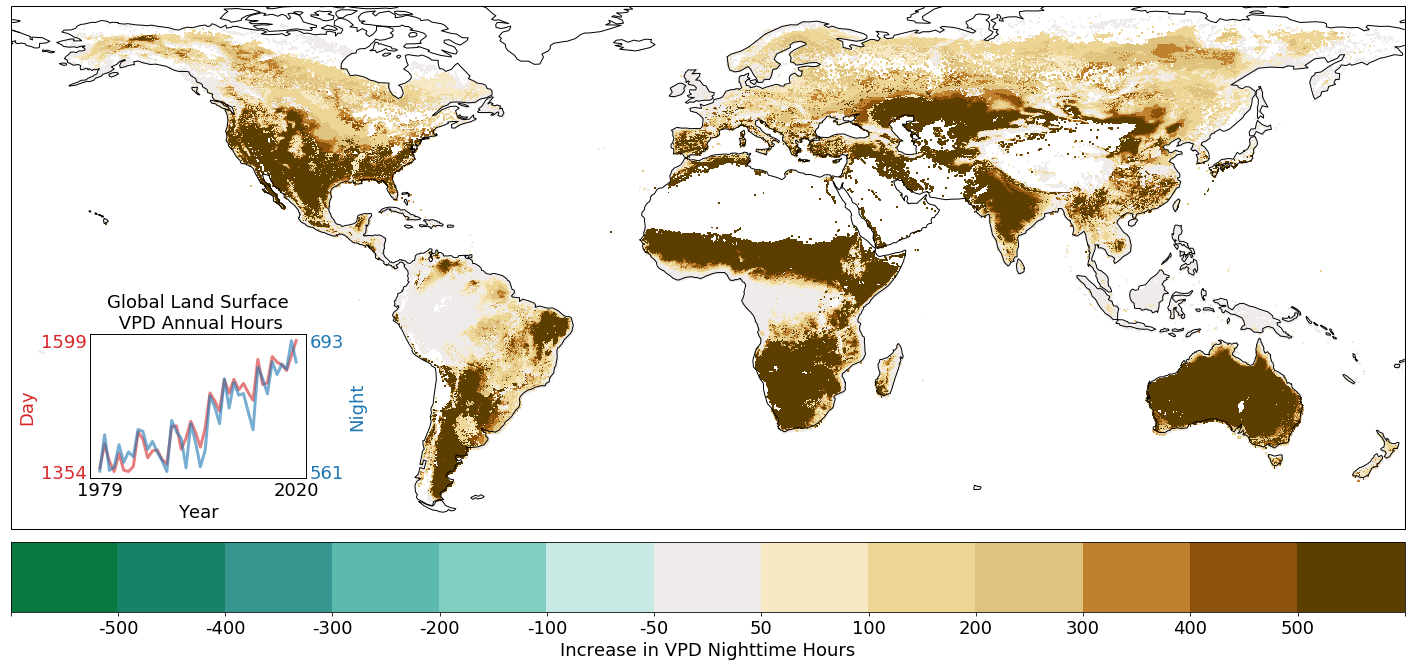

In [23]:
lp_samescale=False

    
font = {'family' : 'normal',
    'weight' : 'medium',
    'size'   : 18}

matplotlib.rc('font', **font)


fname, bounds_list = vpd_files[-2], bounds_entries[-2]
fname = '../fromJohn_Idaho_v3/nighthours_climo19912020.nc'
with rio.open(fname) as src:
    print(src.profile)
    vpd=src.read(1)



vpd_data = vpd
template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
with rio.open(template) as src:
    meta = src.meta
    print(meta)

o_tform = meta['transform']

tform = o_tform.translation(-180,-15) * o_tform

# dif_affine = np.array(meta['transform']) - [0, 0, 0, 0, 0, 0]
# print(dif_affine)

#num_x = meta['width']
#num_y = meta['height']

vnum_x = vpd_data.shape[1]
vnum_y = vpd_data.shape[0]

# incorporate aggregation factor
vtlon = np.linspace(tform.c - tform.a, tform.c+vnum_x*tform.a, vnum_x)
vtlat = np.linspace(tform.f - tform.e, tform.f+vnum_y*tform.e, vnum_y)
vlon2d, vlat2d = np.meshgrid(vtlon, vtlat)

# make data into xarray with location
v_xdata = xr.DataArray(vpd_data, coords=[vtlat, vtlon], dims=['lat', 'lon'])
v_xdata = xr.where(v_xdata == 0, np.nan, v_xdata)
v_xdata = xr.where(v_xdata == -9999, np.nan, v_xdata)

if 'vpdmin' in fname:
    v_xdata/=10

# fig, ax = plt.subplots(1,1, projection=ccrs.PlateCarree(central_longitude=0))
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines()
#ax.gridlines()

# red/blue
colors = [(103,0,31),(178,24,43),(214,96,77),(232, 142, 111),
          (244,165,130),(253,219,199),(240, 235, 235),(209,229,240),(146,197,222), (121, 181, 224),
          (67,147,195),(33,102,172),(5,48,97)]

# purple/green
colors = [(64,0,75),(118,42,131),(153,112,171),(194,165,207),
          (197, 165, 201),(231,212,232),(240, 235, 235),(217,240,211),(166,219,160),(90,174,97),
          (90,174,97),(27,120,55),(0,68,27)]

# bg to brown
colors = [(92, 62, 0),(140,81,10),(191,129,45),(223,194,125),
          (237, 214, 149), (246,232,195),(240, 235, 235),(199,234,229),(128,205,193),(91, 186, 172),
          (53,151,143),(23, 130, 103),(10, 120, 65)]
colors = list(np.array(colors)/255)

colors.reverse()
cmap = matplotlib.colors.ListedColormap(colors)
#bounds = [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500]
bounds = bounds_list
bounds_labels = [''] + bounds + ['']
bounds = [-600] + bounds + [600]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)

cf4 = v_xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
ax.set_ylim(-60, 75)

# ax.set_title('NIGHTTIME %')

cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                   boundaries=bounds, 
                   norm=norm, 
                   cmap=cmap,
                   ticks=bounds)
cb4.set_ticklabels(bounds_labels)
cb4.set_label('Increase in VPD Nighttime Hours')

##############################################################################################################
####################################################### inset plot############################################
##############################################################################################################

#fig, ax1 = plt.subplots(figsize=(20,15))

# add an axis, at origin of size [(ox, oy, sx, sy)]
ax1 = fig.add_axes([0.071, 0.28, 0.15, 0.2])
t = vpd_tm['year']
data1 = vpd_tm['nighthours']
data2 = vpd_tm['dayhours']

lw = 3
alpha=0.6

color = 'tab:red'
ax1.set_xlabel('Year', weight='normal')
ax1.set_ylabel('Day', color=color, weight='normal')
ax1.plot(t, data2, color=color, linewidth=lw, alpha=alpha)
ax1.set_xticks(t)

if not lp_samescale:
    # set the y ticks
    ax1.set_yticks(data2.sort_values())
    top = -1
    bottom = 0
    my_yticks = ax1.get_yticks()
    new_yticks = ['' for _ in my_yticks]
    new_yticks[top] = int(my_yticks[top])
    new_yticks[bottom] = int(my_yticks[bottom])
else:
    # same scale
    ax1.set_ylim([700,2000])
    my_yticks = ax1.get_yticks()
    top = -1
    bottom = 1
    new_yticks = ['' for _ in my_yticks]
    new_yticks[top] = 1855
    new_yticks[bottom] = 875

ax1.set_yticklabels(new_yticks)

ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(length=0)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Night', color=color, weight='normal')  # we already handled the x-label with ax1
ax2.plot(t, data1, color=color, linewidth=lw, alpha=alpha)
ax2.set_xticklabels([''])
ax2.tick_params(axis='y', labelcolor=color, length=0)

if not lp_samescale:
    # set the y ticks
    ax2.set_yticks(data1.sort_values())
    top = -1
    bottom = 0
    my_yticks = ax2.get_yticks()
    new_yticks = ['' for _ in my_yticks]
    new_yticks[top] = int(my_yticks[top])
    new_yticks[bottom] = int(my_yticks[bottom])
else:
    # same scale
    ax2.set_ylim([700,2000])
    my_yticks = ax2.get_yticks()
    top = -1
    bottom = 1
    new_yticks = ['' for _ in my_yticks]
    new_yticks[top] = 1855
    new_yticks[bottom] = 875

ax2.set_yticklabels(new_yticks)

# set the xticks
my_xticks = ax2.get_xticks()
new_xticks = ['' for _ in my_xticks]
left = 0
right = -1
new_xticks[left] = my_xticks[left]
new_xticks[right] = my_xticks[right]
ax2.set_xticklabels(new_xticks)
# ax2.tick_params(axis=u'both', which=u'both',length=0)

plt.title('Global Land Surface\n VPD Annual Hours', fontsize=18)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if lp_samescale:
    fig_name = os.path.basename(fname).split('.')[0]
    plt.savefig(f'../fromJohn_Idaho_v3/nighthours_lineplot_combined_bg2br_samescale.png')
else:
    fig_name = os.path.basename(fname).split('.')[0]
    plt.savefig(f'../fromJohn_Idaho_v3/nighthours_lineplot_combined_bg2br.png')

## try to shift day axis down

{'driver': 'HDF5Image', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 510, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32768.0, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875)}


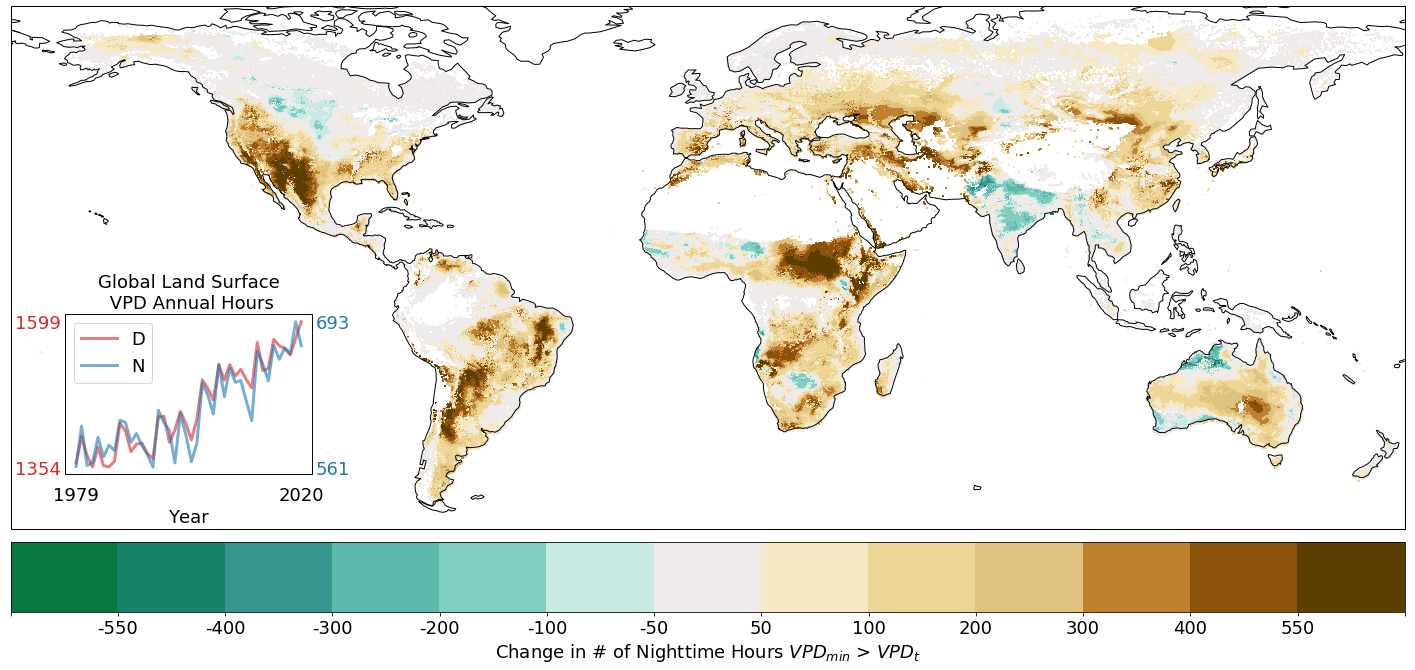

In [24]:
lp_samescale=False

    
font = {'family' : 'normal',
    'weight' : 'medium',
    'size'   : 18}

matplotlib.rc('font', **font)


fname, bounds_list = vpd_files[-2], bounds_entries[-2]
fname = '../fromJohn_Idaho_v3/nighthours_trend.nc'
with rio.open(fname) as src:
    print(src.profile)
    vpd=src.read(1)



vpd_data = vpd
template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
with rio.open(template) as src:
    meta = src.meta
    print(meta)

o_tform = meta['transform']

tform = o_tform.translation(-180,-15) * o_tform

# dif_affine = np.array(meta['transform']) - [0, 0, 0, 0, 0, 0]
# print(dif_affine)

#num_x = meta['width']
#num_y = meta['height']

vnum_x = vpd_data.shape[1]
vnum_y = vpd_data.shape[0]

# incorporate aggregation factor
vtlon = np.linspace(tform.c - tform.a, tform.c+vnum_x*tform.a, vnum_x)
vtlat = np.linspace(tform.f - tform.e, tform.f+vnum_y*tform.e, vnum_y)
vlon2d, vlat2d = np.meshgrid(vtlon, vtlat)

# make data into xarray with location
v_xdata = xr.DataArray(vpd_data, coords=[vtlat, vtlon], dims=['lat', 'lon'])
v_xdata = xr.where(v_xdata == 0, np.nan, v_xdata)
v_xdata = xr.where(v_xdata == -9999, np.nan, v_xdata)

if 'vpdmin' in fname:
    v_xdata/=10

# fig, ax = plt.subplots(1,1, projection=ccrs.PlateCarree(central_longitude=0))
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines()
#ax.gridlines()

# red/blue
colors = [(103,0,31),(178,24,43),(214,96,77),(232, 142, 111),
          (244,165,130),(253,219,199),(240, 235, 235),(209,229,240),(146,197,222), (121, 181, 224),
          (67,147,195),(33,102,172),(5,48,97)]

# purple/green
colors = [(64,0,75),(118,42,131),(153,112,171),(194,165,207),
          (197, 165, 201),(231,212,232),(240, 235, 235),(217,240,211),(166,219,160),(90,174,97),
          (90,174,97),(27,120,55),(0,68,27)]

# bg to brown
colors = [(92, 62, 0),(140,81,10),(191,129,45),(223,194,125),
          (237, 214, 149), (246,232,195),(240, 235, 235),(199,234,229),(128,205,193),(91, 186, 172),
          (53,151,143),(23, 130, 103),(10, 120, 65)]
colors = list(np.array(colors)/255)

colors.reverse()
cmap = matplotlib.colors.ListedColormap(colors)
#bounds = [-500,-400,-300,-200,-100,-50,50,100,200,300,400,500]
bounds = [-550, -400, -300, -200, -100, -50, 50, 100, 200, 300, 400, 550]
#bounds = bounds_list
bounds_labels = [''] + bounds + ['']
bounds = [-600] + bounds + [600]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)

cf4 = v_xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
ax.set_ylim(-60, 75)

# ax.set_title('NIGHTTIME %')

cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                   boundaries=bounds, 
                   norm=norm, 
                   cmap=cmap,
                   ticks=bounds)
cb4.set_ticklabels(bounds_labels)
cb4.set_label(r'Change in # of Nighttime Hours $VPD_{min}$ > $VPD_t$')

##############################################################################################################
####################################################### inset plot############################################
##############################################################################################################

#fig, ax1 = plt.subplots(figsize=(20,15))

# add an axis, at origin of size [(ox, oy, sx, sy)]
delt = .022
ax1 = fig.add_axes([0.071-0.0175, 0.28+0.01, 0.15+delt, 0.2+delt])
t = vpd_tm['year']
data1 = vpd_tm['nighthours']
data2 = vpd_tm['dayhours']

lw = 3
alpha=0.6

color = 'tab:red'
ax1.set_xlabel('Year', weight='normal')
#ax1.set_ylabel('Day', color=color, weight='normal')
dlines = ax1.plot(t, data2, color=color, linewidth=lw, alpha=alpha, label='Day')
ax1.set_xticks(t)


# set the y ticks
ytickvals = data2.sort_values()
# ytickvals = [1734] + list(ytickvals)
ax1.set_yticks(ytickvals)
top = -1
bottom = 0
my_yticks = ax1.get_yticks()
new_yticks = ['' for _ in my_yticks]
new_yticks[top] = int(my_yticks[top])
new_yticks[bottom] = int(my_yticks[bottom])
#new_yticks[bottom] = int(1734)
# ax1.set_ylim([1734, my_yticks[top]+100])


ax1.set_yticklabels(new_yticks)

ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(length=0)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
#ax2.set_ylabel('Night', color=color, weight='normal')  # we already handled the x-label with ax1
nlines = ax2.plot(t, data1, color=color, linewidth=lw, alpha=alpha, label='Night')
ax2.set_xticklabels([''], rotation=45)
ax2.tick_params(axis='y', labelcolor=color, length=0)


# set the y ticks
ytickvals = data1.sort_values()
#ytickvals = [850] + list(ytickvals)
ax2.set_yticks(ytickvals)
top = -1
bottom = 0
my_yticks = ax2.get_yticks()
new_yticks = ['' for _ in my_yticks]
new_yticks[top] = int(my_yticks[top])
new_yticks[bottom] = int(my_yticks[bottom])
#new_yticks[bottom] = int(850)


ax2.set_yticklabels(new_yticks)

# set the xticks
my_xticks = ax2.get_xticks()
new_xticks = ['' for _ in my_xticks]
left = 0
right = -1
new_xticks[left] = my_xticks[left]
new_xticks[right] = my_xticks[right]
ax2.set_xticklabels(new_xticks, rotation=45)
ax1.tick_params(axis='x', pad=12)

# ax2.legend([dlines[0], nlines[0]], ('D', 'N'), loc='lower right')
ax2.legend([dlines[0], nlines[0]], ('D', 'N'), loc='upper left')

plt.title('Global Land Surface\n VPD Annual Hours', fontsize=18)
plt.xticks(rotation=15)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if lp_samescale:
    fig_name = os.path.basename(fname).split('.')[0]
    plt.savefig(f'../fromJohn_Idaho_v3/nighthours_lineplot_combined_bg2br_samescale.png')
else:
    fig_name = os.path.basename(fname).split('.')[0]
    plt.savefig(f'../fromJohn_Idaho_v3/nighthours_lineplot_combined_bg2br.png')

In [25]:
bounds_list

[-500, -400, -300, -200, -100, -50, 50, 100, 200, 300, 400, 500]

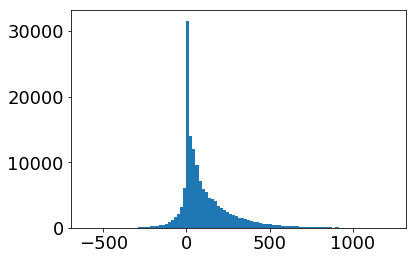

In [26]:
plt.hist(vpd[vpd>-9999].ravel(), bins=100)
plt.show()

In [27]:
vtlat.min(), vtlat.max()

(-52.625, 75.125)